### 0. Setup Workbook

In [8]:
# Ensure the project root is in the Python path
import sys
sys.path.append('/Users/tl759k/Documents/GitHub/work/cursor-analytics')

# Activate the virtual environment (if not already activated)
# This is typically done outside the notebook, but we ensure the path is correct here
import os
os.system('source /Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/bin/activate')

# Re-import the SnowflakeHook after ensuring the path is set
from utils.snowflake_connection import SnowflakeHook


# Load the SQL query from the file
def load_query(file_path):
    with open(file_path, 'r') as file:
        query = file.read()
    snowhook = SnowflakeHook()
    df = snowhook.query_snowflake(query, method='pandas')

    # format decimal to float
    for col in df.columns:
        if df[col].dtype == 'object' and isinstance(df[col].dropna().iloc[0], Decimal):
            df[col] = df[col].astype(float)

    return df

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patheffects as pe
# import plotly.graph_objects as go
import seaborn as sns
import statsmodels.formula.api as smf
from decimal import Decimal

### Read Inputs

In [10]:
all_sms_daco_output = load_query('all_sms_daco_output.sql')

2025-09-15 01:41:37,839 - utils.snowflake_connection - ERROR - Failed to create optimized Spark session: Java gateway process exited before sending its port number
2025-09-15 01:41:37,839 - utils.snowflake_connection - ERROR - Failed to create Spark session: Java gateway process exited before sending its port number


The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.

/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/pyspark/bin/spark-class: line 96: CMD: bad array subscript
head: illegal line count -- -1


2025-09-15 01:41:38,397 - utils.snowflake_connection - INFO - Successfully connected to Snowflake
2025-09-15 01:41:38,398 - utils.snowflake_connection - INFO - Executing query (pandas)


In [11]:
display(all_sms_daco_output[all_sms_daco_output['submarket_id'] == 0])

,submarket_id,mcpd_scenario,spending,applicants,new_dx,wad,hours
0,0,1000,4.669642e+05,8169.743731,1703.735784,11969.157528,136629.136869
1,0,2000,1.328705e+06,11808.890138,2405.857428,16920.316741,190258.651040
2,0,3000,2.254686e+06,13956.571084,2823.832750,19876.235518,222269.328212
3,0,4000,3.036463e+06,15298.070031,3073.467708,21655.563289,240817.524367
4,0,5000,3.797443e+06,16405.958823,3275.364326,23090.265497,256056.970641
5,0,6000,4.425450e+06,17112.736606,3408.040026,24029.971439,266072.319642
6,0,7000,4.965759e+06,17630.457314,3512.724291,24775.138123,273588.690991
7,0,8000,5.418885e+06,18106.955830,3602.525084,25415.959887,280102.242471
8,0,9000,5.807385e+06,18527.999344,3684.558073,26004.698445,285788.006830
9,0,10000,6.118613e+06,18914.321342,3753.626956,26504.556407,290120.197965


### DxO Curve

Pittsburgh Cohort DxO Curve

In [12]:

# dxo_data = {
#     "spending": [10000, 49970, 99940, 149910, 199880, 249850],
#     "dxo_cpih": [15, 15, 15, 15, 15, 16]
# }

dxo_data = {
    "spending": [10000, 49970, 70000],
    "dxo_cpih": [15, 15, 15]
}

# $15
# $15
# $15
# $17
# $24

# $49,970
# $99,940
# $149,910
# $199,880
# $249,850

# Create the DataFrame
df_dxo = pd.DataFrame(dxo_data)

df_dxo

,spending,dxo_cpih
0,10000,15
1,49970,15
2,70000,15


Global DxO Curve (for SMs had peak pay in control)

In [13]:
global_dxo_data = {
    "spending": [1000000, 1363277, 2726554, 4089831, 5453108, 6816385],
    "dxo_cpih": [9, 9, 9, 9, 10, 15],
    "dxo_cpih_15": [15, 15, 15, 15, 15, 15]
}

# Create the DataFrame
df_global_dxo = pd.DataFrame(global_dxo_data)

df_global_dxo


,spending,dxo_cpih,dxo_cpih_15
0,1000000,9,15
1,1363277,9,15
2,2726554,9,15
3,4089831,9,15
4,5453108,10,15
5,6816385,15,15


### Pittsburgh Cohort SMs

##### Find SMs with similar size to Pittsburgh (25 SMs)

In [14]:
sm_bucket = load_query('top_sm.sql')

filtered_sm_bucket = sm_bucket[
    # (sm_bucket['bucket_uh'] >= 0.01) &
    (sm_bucket['bucket_delivs'] >= 150000) &
    (sm_bucket['bucket_delivs'] <= 500000) 
    # (sm_bucket['bucket_spend'] >= 50000) &
    # (sm_bucket['bucket_spend'] <= 100000)
]

# check if avaialble in the daco_spend_to_applicants_curve
available_sm = filtered_sm_bucket[filtered_sm_bucket['submarket_id'].isin(all_sms_daco_output['submarket_id'].unique())]
filtered_sm_bucket_list = available_sm['submarket_id'].unique().tolist()

available_sm

2025-09-15 01:41:39,507 - utils.snowflake_connection - ERROR - Failed to create optimized Spark session: Java gateway process exited before sending its port number
2025-09-15 01:41:39,508 - utils.snowflake_connection - ERROR - Failed to create Spark session: Java gateway process exited before sending its port number


The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.

/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/pyspark/bin/spark-class: line 96: CMD: bad array subscript
head: illegal line count -- -1


2025-09-15 01:41:39,767 - utils.snowflake_connection - INFO - Successfully connected to Snowflake
2025-09-15 01:41:39,769 - utils.snowflake_connection - INFO - Executing query (pandas)


,week,submarket_id,submarket_name,total_deliveries,uh_pct,undersupplied_hours,ideal_online_hours,uh_pct * 100,bucket_delivs,bucket_uh,total_budget,bucket_spend
2324,2025-09-08,167,New Orleans,149255,0.018256,1379.590632,75570.189358,1.825575,150000.0,0.018,51444.0,50000.0
2325,2025-09-08,72,Queens,155890,0.008546,549.160287,64261.800630,0.854567,160000.0,0.009,35556.0,40000.0
2329,2025-09-08,237,Buffalo,168533,0.029269,2190.856204,74853.591715,2.926855,170000.0,0.029,32003.0,30000.0
2330,2025-09-08,334,Greenville,170987,0.016620,1310.272759,78839.312187,1.661954,170000.0,0.017,32218.0,30000.0
2332,2025-09-08,236,Memphis,182631,0.024165,2160.615668,89412.335279,2.416463,180000.0,0.024,74346.0,70000.0
2334,2025-09-08,305,Greensboro,200685,0.008254,712.366568,86305.813873,0.825398,200000.0,0.008,9671.0,10000.0
2337,2025-09-08,79,Louisville,205861,0.011084,1007.469320,90893.599644,1.108405,210000.0,0.011,8117.0,10000.0
2338,2025-09-08,78,Richmond,227532,0.020854,2112.610276,101304.581928,2.085404,230000.0,0.021,47488.0,50000.0
2339,2025-09-08,8,Brooklyn,230645,0.041011,4182.729959,101989.951906,4.101120,230000.0,0.041,90180.0,90000.0
2341,2025-09-08,92,Jacksonville,234040,0.004054,444.192559,109580.209813,0.405358,230000.0,0.004,9603.0,10000.0


In [61]:
filtered_sm_bucket['submarket_id'].unique().tolist()

[62,
 167,
 72,
 86,
 84,
 87,
 237,
 334,
 73,
 236,
 68,
 305,
 96,
 83,
 79,
 78,
 8,
 2,
 92,
 55,
 6,
 81,
 11,
 39,
 17,
 36,
 48,
 37,
 91,
 34,
 31,
 134,
 99,
 32,
 58,
 16,
 25,
 66,
 38,
 30,
 59,
 20,
 56,
 61,
 70,
 33,
 21,
 13,
 63,
 7,
 3]

In [16]:
df_sm81_cohort = all_sms_daco_output[all_sms_daco_output['submarket_id'].isin(filtered_sm_bucket_list)]
df_sm81_cohort = df_sm81_cohort.merge(available_sm[['submarket_id','total_deliveries']], on='submarket_id', how='left')

Weighted Avg by SM Size

In [17]:
def wavg(group, cols, weight_col="tot_delivs"):
    d = group[cols]
    w = group[weight_col]
    return (d.mul(w, axis=0).sum(axis=0)) / w.sum()

# Columns you want to aggregate
agg_cols = [
    'spending','applicants','new_dx','wad','hours'
    # ,'cpih','cpiwad','cpid',
    # 'cp_wad','cp_hour','hours_per_dx',
    # 'inc_spend','inc_apps','inc_new_dx','inc_wad','inc_hours',
    # 'inc_spend_final','inc_apps_final','inc_new_dx_final','inc_wad_final','inc_hours_final',
    # 'cpih_lifetime',   'inc_hours_lifetime'
]

df_sm81_cohort_weighted = (
    df_sm81_cohort
    .groupby("mcpd_scenario")
    .apply(lambda g: wavg(g, agg_cols, weight_col="total_deliveries"))
    .reset_index()
)

df_sm81_cohort_weighted

,mcpd_scenario,spending,applicants,new_dx,wad,hours
0,1000,6955.957486,151.359375,32.789562,231.864459,2571.348680
1,2000,18115.001031,198.529643,42.006370,297.617688,3327.341419
2,3000,32888.596257,234.527302,49.898820,353.527379,3962.048141
3,4000,45027.575630,258.537965,54.725170,388.066232,4351.679743
4,5000,55675.303527,274.632137,58.093252,412.124360,4626.502162
5,6000,64904.202404,285.098058,60.378057,428.219268,4802.872619
6,7000,72760.384871,293.434497,62.177589,440.844727,4940.326157
7,8000,79312.979505,301.988774,63.600011,450.821328,5050.888106
8,9000,84811.908827,306.983172,64.497439,457.135504,5122.120390
9,10000,89448.881964,311.328964,65.184025,462.094802,5180.613751


In [18]:
def calculate_cpih(df_sm81_cohort_weighted):
    df = df_sm81_cohort_weighted.copy()

    df['inc_spend'] = df['spending'].diff()
    df.loc[df.index[0], 'inc_spend'] = df['spending'].iloc[0]

    df['inc_applicants'] = df['applicants'].diff()
    df.loc[df.index[0], 'inc_applicants'] = df['applicants'].iloc[0]

    df['inc_new_dx'] = df['new_dx'].diff()
    df.loc[df.index[0], 'inc_new_dx'] = df['new_dx'].iloc[0]

    df['inc_wad'] = df['wad'].diff()
    df.loc[df.index[0], 'inc_wad'] = df['wad'].iloc[0]

    df['inc_hours'] = df['hours'].diff()
    df.loc[df.index[0], 'inc_hours'] = df['hours'].iloc[0]

    df['inc_hours_lifetime'] = df['inc_new_dx'] * 170

    df['cpih'] = df['inc_spend'] / (df['inc_hours'] * 1.2)
    ## why adjust for cpih
    # DACO applied a more aggressive churn rate of new dx than the actual churn rate, on avg 20% higher

    df['cpih_lifetime'] = df['inc_spend'] / df['inc_hours_lifetime']

    df['cpiwad'] = df['inc_spend'] / df['inc_wad']
    df['actual_mcpd'] = df['inc_spend'] / df['inc_new_dx']

    return df

df_sm81_cohort_weighted = calculate_cpih(df_sm81_cohort_weighted)

df_sm81_cohort_weighted

,mcpd_scenario,spending,applicants,new_dx,wad,hours,inc_spend,inc_applicants,inc_new_dx,inc_wad,inc_hours,inc_hours_lifetime,cpih,cpih_lifetime,cpiwad,actual_mcpd
0,1000,6955.957486,151.359375,32.789562,231.864459,2571.348680,6955.957486,151.359375,32.789562,231.864459,2571.348680,5574.225470,2.254316,1.247879,30.000102,212.139387
1,2000,18115.001031,198.529643,42.006370,297.617688,3327.341419,11159.043546,47.170268,9.216809,65.753228,755.992739,1566.857471,12.300651,7.121926,169.710960,1210.727484
2,3000,32888.596257,234.527302,49.898820,353.527379,3962.048141,14773.595225,35.997659,7.892450,55.909692,634.706722,1341.716425,19.396879,11.010967,264.240327,1871.864383
3,4000,45027.575630,258.537965,54.725170,388.066232,4351.679743,12138.979373,24.010664,4.826350,34.538853,389.631602,820.479481,25.962515,14.794982,351.458671,2515.146986
4,5000,55675.303527,274.632137,58.093252,412.124360,4626.502162,10647.727897,16.094171,3.368082,24.058128,274.822419,572.573978,32.286691,18.596248,442.583396,3161.362223
5,6000,64904.202404,285.098058,60.378057,428.219268,4802.872619,9228.898878,10.465921,2.284805,16.094908,176.370457,388.416822,43.605654,23.760297,573.404894,4039.250415
6,7000,72760.384871,293.434497,62.177589,440.844727,4940.326157,7856.182467,8.336439,1.799532,12.625459,137.453538,305.920492,47.629321,25.680472,622.249242,4365.680156
7,8000,79312.979505,301.988774,63.600011,450.821328,5050.888106,6552.594634,8.554278,1.422422,9.976601,110.561949,241.811722,49.388561,27.097920,656.796286,4606.646363
8,9000,84811.908827,306.983172,64.497439,457.135504,5122.120390,5498.929321,4.994398,0.897428,6.314176,71.232283,152.562724,64.330959,36.043728,870.886337,6127.433738
9,10000,89448.881964,311.328964,65.184025,462.094802,5180.613751,4636.973138,4.345792,0.686586,4.959298,58.493361,116.719701,66.061246,39.727425,935.005857,6753.662195


##### Train Spending <> mCPD <> CPIH curve for DACO

Define training formulas

In [19]:
def _r2_fast(y, yhat):
    """Fast R² on numpy arrays (returns -inf if y is constant)."""
    ss_tot = np.square(y - y.mean()).sum()
    if ss_tot == 0:
        return -np.inf
    ss_res = np.square(y - yhat).sum()
    return 1 - ss_res / ss_tot


def _pick_scale_sat_exp(x, y, grid=None):
    """Grid-search the saturating-exponential *scale* that maximises ordinary-least-squares R²."""
    x = x.astype(float)
    y = y.astype(float)

    if grid is None:
        x_pos = x[x > 0]
        x_max = x_pos.max()
        x_med = np.median(x_pos)
        s_min = 1.0 / (10 * x_max)
        s_max = 10.0 / x_med
        grid = np.geomspace(s_min, s_max, 25)

    best_s, best_r2 = None, -np.inf
    for s in grid:
        tr = 1.0 - np.exp(-s * x)
        X = np.vstack([np.ones_like(tr), tr]).T
        beta = np.linalg.lstsq(X, y, rcond=None)[0]
        r2 = _r2_fast(y, X @ beta)
        if r2 > best_r2:
            best_r2, best_s = r2, s

    return best_s if best_s is not None else 1.0


def run_regression(df, y, x, *, kind="linear", weights=None, bin_column=None, **kwargs):
    """Fit one curve shape via GLM and plot with a unified styling.
       Returns (summary_df, pred_df)
    """
    work = df.copy()

    if kind == "linear":
        reg = x
        formula = f"{y} ~ {reg}"

    elif kind == "log":
        work["_log_x"] = np.log(work[x].replace(0, np.nan))
        reg = "_log_x"
        formula = f"{y} ~ {reg}"

    elif kind == "log_shift":
        shift = kwargs.get("shift", 1.0)
        work["_log_xs"] = np.log(work[x] + shift)
        reg = "_log_xs"
        formula = f"{y} ~ {reg}"

    elif kind == "exp":
        scale = kwargs.get("scale")
        if scale is None:
            xmax = np.nanmax(work[x].values)
            scale = xmax / 10 if xmax > 0 else 1.0
            print(f"[run_regression] Auto-selected scale={scale:.4g} for exp")
        work["_exp_x"] = np.exp(work[x] / scale)
        reg = "_exp_x"
        formula = f"{y} ~ {reg}"

    elif kind == "power":
        p = kwargs.get("p", 2.0)
        work["_pow_x"] = np.power(work[x], p)
        reg = "_pow_x"
        formula = f"{y} ~ {reg}"

    elif kind == "quadratic":
        work["_x2"] = np.square(work[x])
        reg = ["_x2", x]
        formula = f"{y} ~ {x} + _x2"

    elif kind == "sat_exp":
        scale = kwargs.get("scale")
        if scale is None:
            finite_mask = np.isfinite(work[[x, y]]).all(axis=1)
            scale = _pick_scale_sat_exp(work.loc[finite_mask, x].values,
                                        work.loc[finite_mask, y].values)
            print(f"[run_regression] Auto-selected scale={scale:.4g} for sat_exp")
        work["_sat_x"] = 1.0 - np.exp(-scale * work[x])
        reg = "_sat_x"
        formula = f"{y} ~ {reg}"

    elif kind == "hill":
        h = kwargs.get("h", 1.0)
        k_param = kwargs.get("k", 1.0)
        work["_hill_x"] = (work[x] ** h) / (k_param ** h + work[x] ** h)
        reg = "_hill_x"
        formula = f"{y} ~ {reg}"

    else:
        raise ValueError("Unsupported kind: " + kind)

    # Clean rows
    mask = np.isfinite(work[[y] + ([reg] if isinstance(reg, str) else reg)]).all(axis=1)
    if (d := len(work) - mask.sum()) > 0:
        print(f"[run_regression] Dropped {d} non-finite rows for '{kind}'.")
    work = work.loc[mask]
    if len(work) < 3:
        raise ValueError(f"Not enough observations for kind='{kind}'.")

    # Fit model
    model = smf.glm(formula=formula, data=work,
                    var_weights=weights.loc[work.index] if weights is not None else None).fit()
    params = model.params

    # Pretty formulas
    if kind == "linear":
        fstr = f"{y} = {params[x]:.10f}·{x} + {params['Intercept']:.10f}"
    elif kind == "log":
        fstr = f"{y} = {params['_log_x']:.10f}·ln({x}) + {params['Intercept']:.10f}"
    elif kind == "log_shift":
        fstr = f"{y} = {params['_log_xs']:.10f}·ln({x} + {shift}) + {params['Intercept']:.10f}"
    elif kind == "exp":
        fstr = f"{y} = {params['_exp_x']:.10f}·exp({x}/{scale:.3g}) + {params['Intercept']:.10f}"
    elif kind == "power":
        fstr = f"{y} = {params['_pow_x']:.10f}·({x}^{p}) + {params['Intercept']:.10f}"
    elif kind == "quadratic":
        fstr = f"{y} = {params['_x2']:.10f}·{x}² + {params[x]:.3f}·{x} + {params['Intercept']:.10f}"
    elif kind == "sat_exp":
        fstr = f"{y} = {params['_sat_x']:.10f}·(1 − exp(−{scale:.3g}·{x})) + {params['Intercept']:.10f}"
    else:  # hill
        h = kwargs.get("h", 1.0); k_param = kwargs.get("k", 1.0)
        fstr = f"{y} = {params['_hill_x']:.10f}·({x}^{h})/({k_param}^{h} + {x}^{h}) + {params['Intercept']:.10f}"

    # Pseudo R² fallback
    r2 = getattr(model, "prsquared", 1 - model.deviance / model.null_deviance)

    # Predictions
    x_fit = np.linspace(df[x].min(), df[x].max(), 500)
    pred_df = pd.DataFrame({x: x_fit})

    if kind == "linear":
        pass
    elif kind == "log":
        pred_df["_log_x"] = np.log(pred_df[x])
    elif kind == "log_shift":
        pred_df["_log_xs"] = np.log(pred_df[x] + shift)
    elif kind == "exp":
        pred_df["_exp_x"] = np.exp(pred_df[x] / scale)
    elif kind == "power":
        pred_df["_pow_x"] = np.power(pred_df[x], p)
    elif kind == "quadratic":
        pred_df["_x2"] = np.square(pred_df[x])
    elif kind == "sat_exp":
        pred_df["_sat_x"] = 1.0 - np.exp(-scale * pred_df[x])
    else:  # hill
        pred_df["_hill_x"] = (pred_df[x] ** h) / (k_param ** h + pred_df[x] ** h)

    y_fit = model.predict(pred_df)
    pred_df[y] = y_fit

    # Plot
    import seaborn as sns
    plt.figure(figsize=(7, 4))
    if bin_column and bin_column in df.columns:
        unique_bins = df[bin_column].dropna().unique()
        palette = sns.color_palette("tab10", len(unique_bins))
        bin_color_map = dict(zip(unique_bins, palette))
        colors = df[bin_column].map(bin_color_map)
        plt.scatter(df[x], df[y], c=colors, alpha=0.5)
        for label, color in bin_color_map.items():
            plt.scatter([], [], c=[color], label=str(label))
    else:
        plt.scatter(df[x], df[y], alpha=0.5, label="Actual")

    plt.plot(x_fit, y_fit, "r-", label=f"{kind} (R²={r2:.3f})")
    plt.title(f"{kind.replace('_', ' ').title()} fit: {y} vs {x}")
    plt.xlabel(x); plt.ylabel(y)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    summary = pd.DataFrame({"metric": [y], "formula": [fstr], "r2": [round(r2, 4)]})
    return summary, pred_df


def fit_all_curves(df, x_col, y_col, *, shapes=None, weights=None, bin_columns=None, **per_shape_kwargs):
    """Fit multiple curve shapes and summarise the results.
       Returns: (best_kind, best_formula, best_r2, results_df, best_fit_df)
    """
    if shapes is None:
        shapes = SHAPES

    results = []
    fitted_dfs = {}

    for kind in shapes:
        kw = per_shape_kwargs.get(kind, {})
        try:
            summ, pred_df = run_regression(df, y_col, x_col, kind=kind,
                                           weights=weights, bin_column=bin_columns, **kw)
            formula = summ.loc[0, "formula"]
            r2 = summ.loc[0, "r2"]
            results.append((kind, formula, r2))
            fitted_dfs[kind] = pred_df
        except Exception as err:
            print(f"[{kind}] FAILED → {err}")
            results.append((kind, None, -np.inf))
            fitted_dfs[kind] = None

    results_df = pd.DataFrame(results, columns=["kind", "formula", "r2"])

    print("\nFitted Models:")
    for kind, formula, r2 in results:
        if formula is not None:
            print(f"{kind:<10}: {formula}   (R²={r2:.4f})")
        else:
            print(f"{kind:<10}: <failed>")

    best_kind, best_formula, best_r2 = max(results, key=lambda t: t[2])
    if best_formula is not None:
        print(f"\nBest Model → {best_kind}  (R²={best_r2:.4f})")
        best_fit_df = fitted_dfs[best_kind]
    else:
        print("\nNo model fit succeeded.")
        best_fit_df = None

    return best_kind, best_formula, best_r2, results_df, best_fit_df


##### Spending <> mCPD

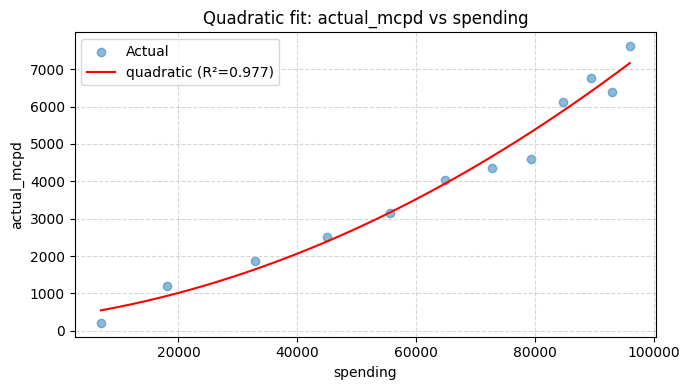


Fitted Models:
quadratic : actual_mcpd = 0.0000005071·spending² + 0.022·spending + 369.7712282605   (R²=0.9768)

Best Model → quadratic  (R²=0.9768)


In [20]:
# SHAPES = ["linear", "log", "sat_exp", "hill", "exp", "power", "quadratic"]
SHAPES = ["quadratic"]

best_kind, best_formula, best_r2, results_df, best_fit_df = fit_all_curves(
    df_sm81_cohort_weighted,
    x_col="spending",
    y_col="actual_mcpd",
    sat_exp=dict(scale=None),
    hill=dict(h=2, k=1000),
    power=dict(p=2.0),
)

# results_df   # summary of all shapes
# print(best_fit_df.head())  # predictions for best model


In [21]:
df_spending_mcpd = best_fit_df.copy()
df_spending_mcpd

,spending,_x2,actual_mcpd
0,6955.957486,4.838534e+07,547.840045
1,7134.411007,5.089982e+07,553.054010
2,7312.864528,5.347799e+07,558.300274
3,7491.318048,5.611985e+07,563.578837
4,7669.771569,5.882540e+07,568.889700
...,...,...,...
495,95290.450349,9.080270e+09,7077.833215
496,95468.903870,9.114312e+09,7099.035360
497,95647.357391,9.148417e+09,7120.269804
498,95825.810912,9.182586e+09,7141.536548


In [22]:
# Quadratic coefficients from your fitted model
a = 0.000001     # coefficient for spending²
b = 0.020        # coefficient for spending
c = 383.472536   # intercept

# Function to solve quadratic equation a*x^2 + b*x + c = y_target
def solve_for_spending(y_target):
    A = a
    B = b
    C = c - y_target
    
    D = B**2 - 4*A*C  # discriminant
    if D < 0:
        return np.nan  # no real solution
    sqrt_D = np.sqrt(D)
    x1 = (-B + sqrt_D) / (2*A)
    x2 = (-B - sqrt_D) / (2*A)
    # pick the positive root (since spending must be > 0)
    roots = [val for val in (x1, x2) if val > 0]
    return max(roots) if roots else np.nan

# Target actual_mcpd values
targets = np.arange(1000, 12001, 1000)  # from 1000 to 12000 step 1000


# Calculate spending for each target
results = [(t, solve_for_spending(t)) for t in targets]

# Save in DataFrame
df_mcpd_spending = pd.DataFrame(results, columns=["mcpd_target", "pred_spending"])

df_mcpd_spending


,mcpd_target,pred_spending
0,1000,16768.030634
1,2000,31430.996416
2,3000,42120.317190
3,4000,50963.328846
4,5000,58676.979141
5,6000,65607.720928
6,7000,71954.423090
7,8000,77843.767360
8,9000,83362.345001
9,10000,88572.447793


##### mCPD <> mCPIH

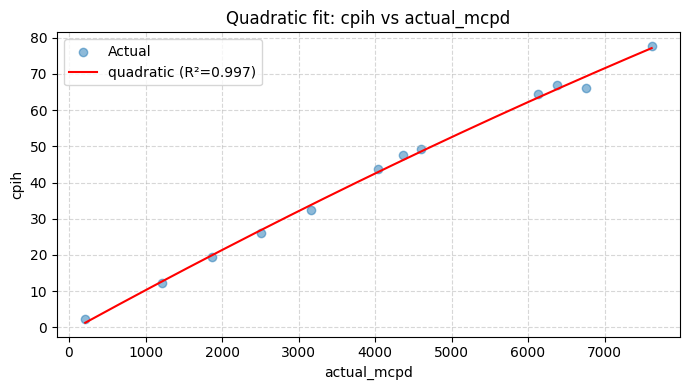


Fitted Models:
quadratic : cpih = -0.0000001757·actual_mcpd² + 0.012·actual_mcpd + -1.1868665901   (R²=0.9967)

Best Model → quadratic  (R²=0.9967)


In [23]:
# SHAPES = ["linear", "log", "sat_exp", "hill", "exp", "power", "quadratic"]
SHAPES = ["quadratic"]

best_kind, best_formula, best_r2, results_df, best_fit_df = fit_all_curves(
    df_sm81_cohort_weighted,
    x_col="actual_mcpd",
    y_col="cpih",
    sat_exp=dict(scale=None),
    hill=dict(h=2, k=1000),
    power=dict(p=2.0),
)

# results_df   # summary of all shapes
# print(best_fit_df.head())  # predictions for best model


In [24]:
df_mpcd_cpih = best_fit_df.copy()
df_mpcd_cpih

,actual_mcpd,_x2,cpih
0,212.139387,4.500312e+04,1.270496
1,226.976257,5.151822e+04,1.441770
2,241.813128,5.847359e+04,1.612968
3,256.649999,6.586922e+04,1.784087
4,271.486870,7.370512e+04,1.955130
...,...,...,...
495,7556.390434,5.709904e+07,76.594586
496,7571.227305,5.732348e+07,76.727574
497,7586.064176,5.754837e+07,76.860485
498,7600.901047,5.777370e+07,76.993318


##### mCPD <> mCPIH Lifetime

/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/statsmodels/genmod/gen

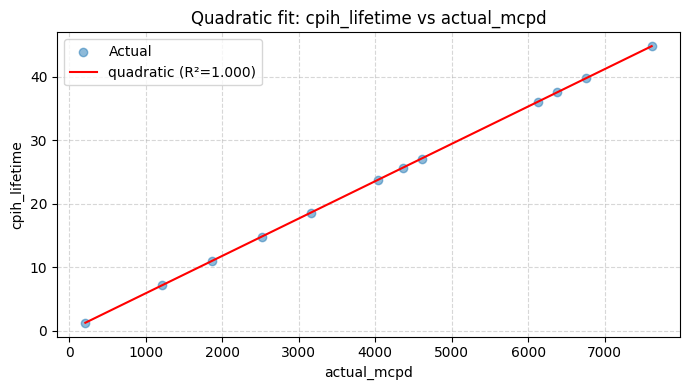


Fitted Models:
quadratic : cpih_lifetime = -0.0000000000·actual_mcpd² + 0.006·actual_mcpd + -0.0000000000   (R²=1.0000)

Best Model → quadratic  (R²=1.0000)


In [25]:
# SHAPES = ["linear", "log", "sat_exp", "hill", "exp", "power", "quadratic"]
SHAPES = ["quadratic"]

best_kind, best_formula, best_r2, results_df, best_fit_df = fit_all_curves(
    df_sm81_cohort_weighted,
    x_col="actual_mcpd",
    y_col="cpih_lifetime",
    sat_exp=dict(scale=None),
    hill=dict(h=2, k=1000),
    power=dict(p=2.0),
)

# results_df   # summary of all shapes
# print(best_fit_df.head())  # predictions for best model


In [26]:
df_mpcd_cpih_lifetime = best_fit_df.copy()
df_mpcd_cpih_lifetime.head()

,actual_mcpd,_x2,cpih_lifetime
0,212.139387,45003.119384,1.247879
1,226.976257,51518.221465,1.335154
2,241.813128,58473.589016,1.422430
3,256.649999,65869.222037,1.509706
4,271.486870,73705.120529,1.596982


In [27]:
# Step 1: spending range (10k to 150k in steps of 10k)
spending = np.arange(10000, 70001, 10000)

# Step 2: MCPD formula (replace coefficients with yours)
def mcpd_formula(s):
    """
    Fitted Models:
    quadratic : actual_mcpd = 0.000001·spending² + 0.020·spending + 383.472766   (R²=0.9623)
    """
    return (0.000001*s**2 + 0.020*s + 383.472766)

# Step 3: CPIH formula in terms of MCPD
def cpih_formula(m):
    """
    Fitted Models:
    quadratic : cpih = -0.0000001·actual_mcpd² + 0.012·actual_mcpd + -1.542277   (R²=0.9965)
    Best Model → quadratic  (R²=0.9965)
    """
    return (-0.0000001*m**2 + 0.012*m + -1.542277)

def cpih_lifetime_formula(m):
    """
    Fitted Models:
    quadratic : cpih_lifetime = -0.000000·actual_mcpd² + 0.006·actual_mcpd + -0.000000   (R²=1.0000)
    Best Model → quadratic  (R²=0.9965)
    """
    return (-0.0000001*m**2 + 0.006*m + -0.000000 )


# Step 4: Compute values
mcpd = mcpd_formula(spending)
cpih = cpih_formula(mcpd)
cpih_lifetime = cpih_lifetime_formula(mcpd)

# Step 5: Build dataframe
df_new = pd.DataFrame({
    "spending": spending,
    "mcpd": mcpd,
    "cpih": cpih,
    "cpih_lifetime": cpih_lifetime
})

df_new


,spending,mcpd,cpih,cpih_lifetime
0,10000,683.472766,6.612683,4.054123
1,20000,1183.472766,12.519335,6.960776
2,30000,1883.472766,20.704649,10.946090
3,40000,2783.472766,31.084624,15.926065
4,50000,3883.472766,43.551260,21.792701
5,60000,5183.472766,57.972557,28.413998
6,70000,6683.472766,74.192515,35.633956


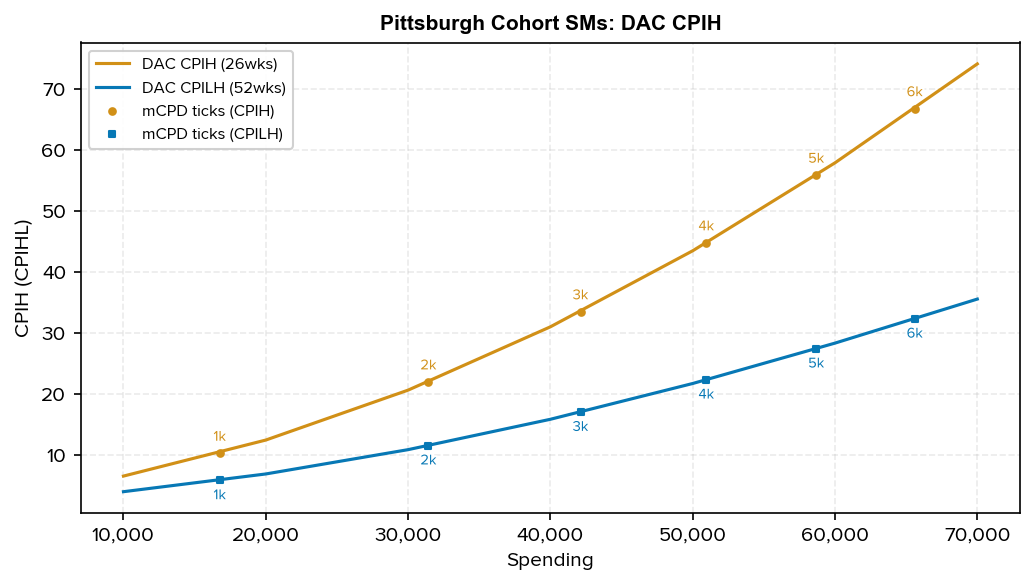

In [28]:
mcpd_levels = np.arange(1000, 6001, 1000)  # 1k..9k (adjust as needed)

a, b, c = 1e-6, 0.020, 383.472766

def spend_from_mcpd(m):
    D = b**2 - 4*a*(c - m)
    return (-b + np.sqrt(D)) / (2*a)

# Exact spending values that produce those MCPD levels
spending_marks = spend_from_mcpd(mcpd_levels)
cpih_marks = cpih_formula(mcpd_levels)
cpih_lifetime_marks = cpih_lifetime_formula(mcpd_levels)

plt.rcParams.update({
    "figure.dpi": 150,                   # crisp display at normal size
    "savefig.dpi": 300,                  # high-res export
    "font.family": ["Proxima Nova", "Helvetica Neue", "Arial"],
    "axes.grid": True,
    "grid.alpha": 0.25,
    "grid.linestyle": "--",
    "axes.linewidth": 0.8,              
})

colors = {"cpih": "#d19017", "cpih_lifetime": "#0778b5", "dxo": "#403f3e"}

fig, ax = plt.subplots(figsize=(7, 4))   # regular size

line1, = ax.plot(df_new["spending"], df_new["cpih"], label="DAC CPIH (26wks)", color=colors["cpih"], linewidth=1.5, zorder=2)
line2, = ax.plot(df_new["spending"], df_new["cpih_lifetime"], label="DAC CPILH (52wks)", color=colors["cpih_lifetime"], linewidth=1.5, zorder=2)
# line3, = ax.plot(df_dxo["spending"], df_dxo["dxo_cpih"], label="DxO CPIH ($15)", color=colors["dxo"], linestyle="--", linewidth=1.5, zorder=1)

# 5) Tick markers (smaller, same color as lines)
ax.scatter(spending_marks, cpih_marks, marker='o', s=10, color=colors["cpih"], zorder=3)
ax.scatter(spending_marks, cpih_lifetime_marks, marker='s', s=10, color=colors["cpih_lifetime"], zorder=3)

# 6) Annotations (CPIH above, Lifetime below) with subtle halo for readability
halo = [pe.withStroke(linewidth=2, foreground="white")]
for s, y, lvl in zip(spending_marks, cpih_marks, mcpd_levels):
    ax.annotate(f"{int(lvl/1000)}k", (s, y), xytext=(0, 6), textcoords="offset points", ha="center", fontsize=7, color=colors["cpih"], path_effects=halo)

for s, y, lvl in zip(spending_marks, cpih_lifetime_marks, mcpd_levels):
    ax.annotate(f"{int(lvl/1000)}k", (s, y), xytext=(0, -9), textcoords="offset points", ha="center", fontsize=7, color=colors["cpih_lifetime"], path_effects=halo)

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.8)
    spine.set_color("black")

ax.set_xlabel("Spending")
ax.set_ylabel("CPIH (CPIHL)")
# ax.set_title("Pittsburgh Cohort SMs: DAC vs DxO CPIH", fontfamily="Arial", fontweight="bold", fontsize = 10)
ax.set_title("Pittsburgh Cohort SMs: DAC CPIH", fontfamily="Arial", fontweight="bold", fontsize = 10)
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))  # commas on x

mcpd_handle1 = ax.scatter([], [], marker='o', s=10, color=colors["cpih"], label="mCPD ticks (CPIH)")
mcpd_handle2 = ax.scatter([], [], marker='s', s=10, color=colors["cpih_lifetime"], label="mCPD ticks (CPILH)")
# ax.legend(handles=[line1, line2, line3, mcpd_handle1, mcpd_handle2], fontsize=8, framealpha=0.9, loc="upper left")
ax.legend(handles=[line1, line2, mcpd_handle1, mcpd_handle2], fontsize=8, framealpha=0.9, loc="upper left")
fig.tight_layout()
plt.show()

## Global

#### SM0 View

##### Prepare

In [29]:
df_sm0 = all_sms_daco_output[all_sms_daco_output['submarket_id'] == 0]
df_sm0 

,submarket_id,mcpd_scenario,spending,applicants,new_dx,wad,hours
0,0,1000,4.669642e+05,8169.743731,1703.735784,11969.157528,136629.136869
1,0,2000,1.328705e+06,11808.890138,2405.857428,16920.316741,190258.651040
2,0,3000,2.254686e+06,13956.571084,2823.832750,19876.235518,222269.328212
3,0,4000,3.036463e+06,15298.070031,3073.467708,21655.563289,240817.524367
4,0,5000,3.797443e+06,16405.958823,3275.364326,23090.265497,256056.970641
5,0,6000,4.425450e+06,17112.736606,3408.040026,24029.971439,266072.319642
6,0,7000,4.965759e+06,17630.457314,3512.724291,24775.138123,273588.690991
7,0,8000,5.418885e+06,18106.955830,3602.525084,25415.959887,280102.242471
8,0,9000,5.807385e+06,18527.999344,3684.558073,26004.698445,285788.006830
9,0,10000,6.118613e+06,18914.321342,3753.626956,26504.556407,290120.197965


In [30]:
df_sm0_calc = calculate_cpih(df_sm0)
df_sm0_calc

,submarket_id,mcpd_scenario,spending,applicants,new_dx,wad,hours,inc_spend,inc_applicants,inc_new_dx,inc_wad,inc_hours,inc_hours_lifetime,cpih,cpih_lifetime,cpiwad,actual_mcpd
0,0,1000,4.669642e+05,8169.743731,1703.735784,11969.157528,136629.136869,466964.214273,8169.743731,1703.735784,11969.157528,136629.136869,289635.083227,2.848125,1.612250,39.013958,274.082530
1,0,2000,1.328705e+06,11808.890138,2405.857428,16920.316741,190258.651040,861740.667110,3639.146407,702.121644,4951.159213,53629.514172,119360.679489,13.390336,7.219636,174.048264,1227.338132
2,0,3000,2.254686e+06,13956.571084,2823.832750,19876.235518,222269.328212,925980.824683,2147.680946,417.975322,2955.918777,32010.677171,71055.804786,24.106041,13.031741,313.263285,2215.395923
3,0,4000,3.036463e+06,15298.070031,3073.467708,21655.563289,240817.524367,781777.335867,1341.498947,249.634958,1779.327771,18548.196155,42437.942788,35.123691,18.421660,439.366680,3131.682131
4,0,5000,3.797443e+06,16405.958823,3275.364326,23090.265497,256056.970641,760979.724742,1107.888791,201.896618,1434.702208,15239.446274,34322.425104,41.612389,22.171502,530.409531,3769.155379
5,0,6000,4.425450e+06,17112.736606,3408.040026,24029.971439,266072.319642,628007.121212,706.777783,132.675700,939.705942,10015.349001,22554.868981,52.253723,27.843528,668.301745,4733.399724
6,0,7000,4.965759e+06,17630.457314,3512.724291,24775.138123,273588.690991,540308.945270,517.720708,104.684265,745.166684,7516.371349,17796.325069,59.903567,30.360703,725.084678,5161.319561
7,0,8000,5.418885e+06,18106.955830,3602.525084,25415.959887,280102.242471,453125.915792,476.498516,89.800793,640.821763,6513.551480,15266.134884,57.972203,29.681771,707.101322,5045.901027
8,0,9000,5.807385e+06,18527.999344,3684.558073,26004.698445,285788.006830,388500.293233,421.043514,82.032989,588.738559,5685.764359,13945.608058,56.940496,27.858254,659.885933,4735.903201
9,0,10000,6.118613e+06,18914.321342,3753.626956,26504.556407,290120.197965,311227.886167,386.321999,69.068883,499.857962,4332.191136,11741.710076,59.867297,26.506180,622.632647,4506.050678


In [31]:
df_sm0_calc['avg_cpih'] = df_sm0_calc['spending'] / df_sm0_calc['hours']
df_sm0_calc['avg_cpwad'] = df_sm0_calc['spending'] / df_sm0_calc['wad']
df_sm0_calc['hours_per_dx'] = df_sm0_calc['hours'] / df_sm0_calc['wad']
df_sm0_calc_output = df_sm0_calc[['actual_mcpd', 'spending','applicants', 'new_dx', 'hours', 'wad','cpih','cpih_lifetime', 'avg_cpih', 'avg_cpwad', 'hours_per_dx']]
df_sm0_calc_output

,actual_mcpd,spending,applicants,new_dx,hours,wad,cpih,cpih_lifetime,avg_cpih,avg_cpwad,hours_per_dx
0,274.082530,4.669642e+05,8169.743731,1703.735784,136629.136869,11969.157528,2.848125,1.612250,3.417750,39.013958,11.415101
1,1227.338132,1.328705e+06,11808.890138,2405.857428,190258.651040,16920.316741,13.390336,7.219636,6.983677,78.527187,11.244391
2,2215.395923,2.254686e+06,13956.571084,2823.832750,222269.328212,19876.235518,24.106041,13.031741,10.143935,113.436254,11.182667
3,3131.682131,3.036463e+06,15298.070031,3073.467708,240817.524367,21655.563289,35.123691,18.421660,12.608979,140.216304,11.120354
4,3769.155379,3.797443e+06,16405.958823,3275.364326,256056.970641,23090.265497,41.612389,22.171502,14.830460,164.460767,11.089390
5,4733.399724,4.425450e+06,17112.736606,3408.040026,266072.319642,24029.971439,52.253723,27.843528,16.632508,184.163760,11.072519
6,5161.319561,4.965759e+06,17630.457314,3512.724291,273588.690991,24775.138123,59.903567,30.360703,18.150454,200.433144,11.042872
7,5045.901027,5.418885e+06,18106.955830,3602.525084,280102.242471,25415.959887,57.972203,29.681771,19.346096,213.207952,11.020723
8,4735.903201,5.807385e+06,18527.999344,3684.558073,285788.006830,26004.698445,56.940496,27.858254,20.320604,223.320607,10.989860
9,4506.050678,6.118613e+06,18914.321342,3753.626956,290120.197965,26504.556407,59.867297,26.506180,21.089924,230.851361,10.946050


##### Spending <> mCPD

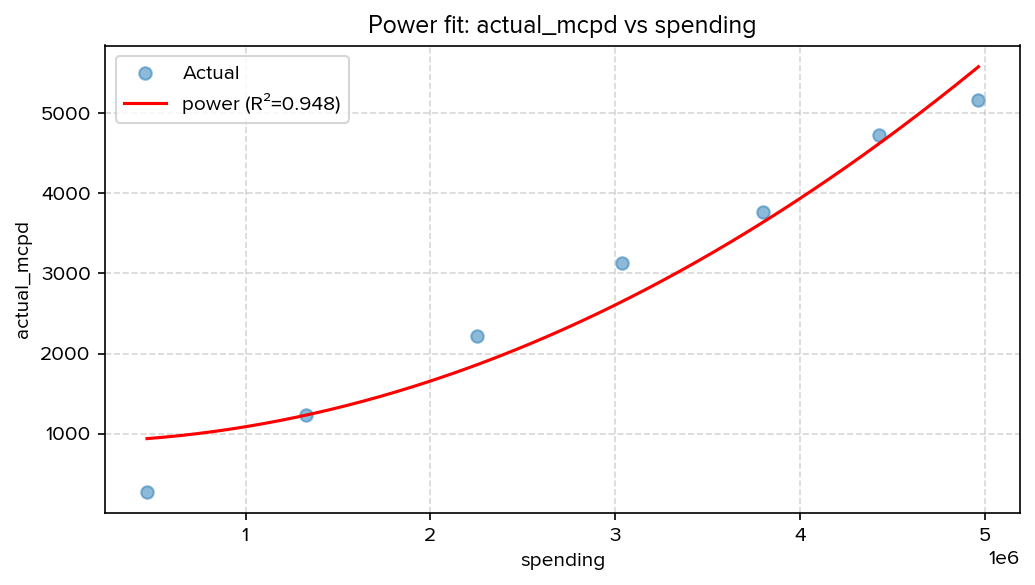


Fitted Models:
power     : actual_mcpd = 0.0000000002·(spending^2.0) + 896.8507731041   (R²=0.9482)

Best Model → power  (R²=0.9482)


In [32]:
# SHAPES = ["linear", "log", "sat_exp", "hill", "exp", "power", "quadratic"]
SHAPES = ["power"]

best_kind, best_formula, best_r2, results_df, best_fit_df = fit_all_curves(
    df_sm0_calc[df_sm0_calc['spending'] < 5000000],
    x_col="spending",
    y_col="actual_mcpd",
    sat_exp=dict(scale=None),
    hill=dict(h=2, k=1000),
    power=dict(p=2.0),
)


In [33]:
df_spending_mcpd = best_fit_df.copy()
df_spending_mcpd.head()

,spending,_pow_x,actual_mcpd
0,466964.214273,2.180556e+11,938.262993
1,475979.834751,2.265568e+11,939.877511
2,484995.455230,2.352206e+11,941.522902
3,494011.075709,2.440469e+11,943.199167
4,503026.696188,2.530359e+11,944.906305


##### mCPD <> CPIH

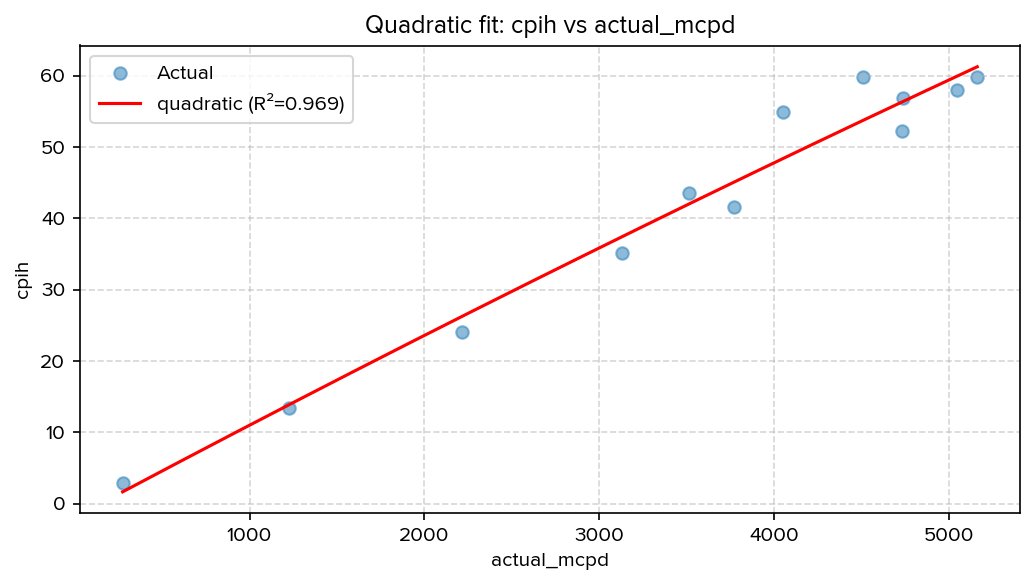


Fitted Models:
quadratic : cpih = -0.0000001625·actual_mcpd² + 0.013·actual_mcpd + -1.9223878395   (R²=0.9687)

Best Model → quadratic  (R²=0.9687)


In [34]:
# SHAPES = ["linear", "log", "sat_exp", "hill", "exp", "power", "quadratic"]
SHAPES = ["quadratic"]

best_kind, best_formula, best_r2, results_df, best_fit_df = fit_all_curves(
    df_sm0_calc,
    x_col="actual_mcpd",
    y_col="cpih",
    sat_exp=dict(scale=None),
    hill=dict(h=2, k=1000),
    power=dict(p=2.0),
)

# results_df   # summary of all shapes
# print(best_fit_df.head())  # predictions for best model


In [35]:
df_mpcd_cpih = best_fit_df.copy()
df_mpcd_cpih

,actual_mcpd,_x2,cpih
0,274.082530,7.512123e+04,1.651087
1,283.876592,8.058592e+04,1.778329
2,293.670655,8.624245e+04,1.905541
3,303.464717,9.209083e+04,2.032721
4,313.258779,9.813106e+04,2.159871
...,...,...,...
495,5122.143313,2.623635e+07,60.825242
496,5131.937375,2.633678e+07,60.937055
497,5141.731437,2.643740e+07,61.048838
498,5151.525499,2.653821e+07,61.160589


##### mCPD <> mCPILH

/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


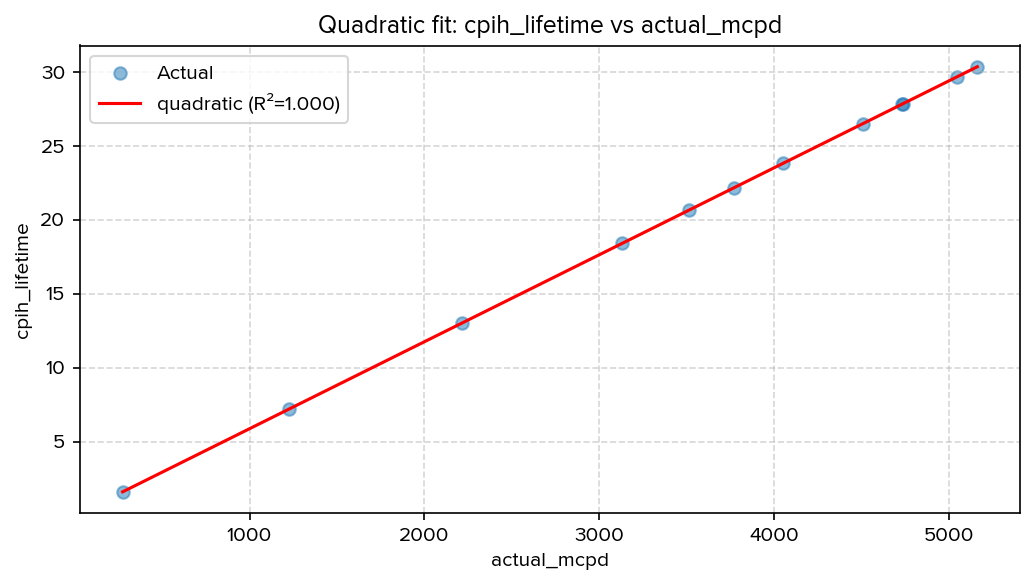


Fitted Models:
quadratic : cpih_lifetime = 0.0000000000·actual_mcpd² + 0.006·actual_mcpd + -0.0000000001   (R²=1.0000)

Best Model → quadratic  (R²=1.0000)


In [36]:
# SHAPES = ["linear", "log", "sat_exp", "hill", "exp", "power", "quadratic"]
SHAPES = ["quadratic"]

best_kind, best_formula, best_r2, results_df, best_fit_df = fit_all_curves(
    df_sm0_calc,
    x_col="actual_mcpd",
    y_col="cpih_lifetime",
    sat_exp=dict(scale=None),
    hill=dict(h=2, k=1000),
    power=dict(p=2.0),
)

# results_df   # summary of all shapes
# print(best_fit_df.head())  # predictions for best model


In [37]:
df_mpcd_cpih_lifetime = best_fit_df.copy()
df_mpcd_cpih_lifetime

,actual_mcpd,_x2,cpih_lifetime
0,274.082530,7.512123e+04,1.612250
1,283.876592,8.058592e+04,1.669862
2,293.670655,8.624245e+04,1.727474
3,303.464717,9.209083e+04,1.785087
4,313.258779,9.813106e+04,1.842699
...,...,...,...
495,5122.143313,2.623635e+07,30.130255
496,5131.937375,2.633678e+07,30.187867
497,5141.731437,2.643740e+07,30.245479
498,5151.525499,2.653821e+07,30.303091


##### Plot the chart

In [38]:
# Step 1: spending range (10k to 150k in steps of 10k)
spending = np.arange(1000000, 7000001, 1000000)

# Step 2: MCPD formula (replace coefficients with yours)
def mcpd_formula(s):
    """
    Fitted Models:
    quadratic : actual_mcpd = 0.000000·spending² + 0.001·spending + -221.640309   (R²=0.9978)
    Fitted Models:
    power     : actual_mcpd = 0.0000000002·(spending^2.0) + 896.8507731041   (R²=0.9482)
    """
    # return (0.00000000001*s**2 + 0.001*s + -221.640309)
    return (0.0000000002*s**2 + 896.8507731041)

# Step 3: CPIH formula in terms of MCPD
def cpih_formula(m):
    """
    Fitted Models:
    quadratic : cpih = -0.000000·actual_mcpd² + 0.013·actual_mcpd + -1.922388   (R²=0.9687)
    Best Model → quadratic  (R²=0.9965)
    """
    return (-0.00000000001*m**2 + 0.013*m +  -1.922388)

def cpih_lifetime_formula(m):
    """
    Fitted Models:
    quadratic : cpih_lifetime = -0.000000·actual_mcpd² + 0.006·actual_mcpd + -0.000000   (R²=1.0000)
    Best Model → quadratic  (R²=0.9965)
    """
    return (-0.00000000001*m**2 + 0.006*m + -0.000000 )


# Step 4: Compute values
mcpd = mcpd_formula(spending)
cpih = cpih_formula(mcpd)
cpih_lifetime = cpih_lifetime_formula(mcpd)

# Step 5: Build dataframe
df_new = pd.DataFrame({
    "spending": spending,
    "mcpd": mcpd,
    "cpih": cpih,
    "cpih_lifetime": cpih_lifetime
})

df_new


,spending,mcpd,cpih,cpih_lifetime
0,1000000,1096.850773,12.336660,6.581093
1,2000000,1696.850773,20.136643,10.181076
2,3000000,2696.850773,33.136599,16.181032
3,4000000,4096.850773,51.336504,24.580937
4,5000000,5896.850773,74.736324,35.380757
5,6000000,8096.850773,103.336016,48.580449
6,7000000,10696.850773,137.135528,64.179960


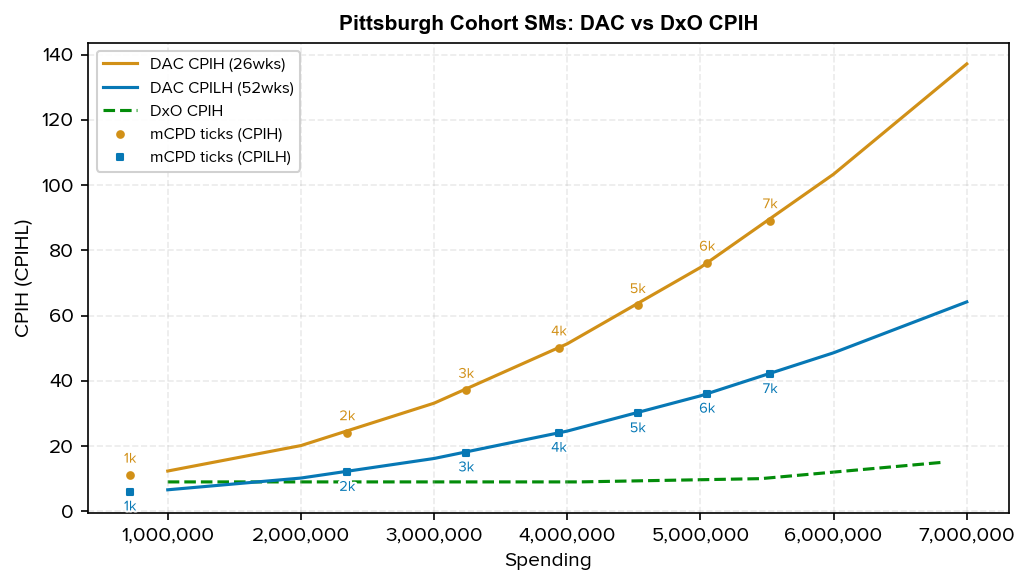

In [39]:
mcpd_levels = np.arange(1000, 7001, 1000)  # 1k..9k (adjust as needed)

# a, b, c = 0.00000000001, 0.001, -221.640309

# def spend_from_mcpd(m):
#     D = b**2 - 4*a*(c - m)
#     return (-b + np.sqrt(D)) / (2*a)

#    return (0.0000000002*s**2 + 896.8507731041)

a = 0.0000000002
c = 896.8507731041 


def spend_from_mcpd(m):
    m = np.asarray(m)  # ensure NumPy array
    # if np.any(m <= c):
        # raise ValueError(f"Some MCPD values are <= {c}, spending would be undefined.")
    return np.sqrt((m - c) / a)


# Exact spending values that produce those MCPD levels
spending_marks = spend_from_mcpd(mcpd_levels)
cpih_marks = cpih_formula(mcpd_levels)
cpih_lifetime_marks = cpih_lifetime_formula(mcpd_levels)

plt.rcParams.update({
    "figure.dpi": 150,                   # crisp display at normal size
    "savefig.dpi": 300,                  # high-res export
    "font.family": ["Proxima Nova", "Helvetica Neue", "Arial"],
    "axes.grid": True,
    "grid.alpha": 0.25,
    "grid.linestyle": "--",
    "axes.linewidth": 0.8,              
})

colors = {"cpih": "#d19017", "cpih_lifetime": "#0778b5", "dxo": "#038c0a"}

fig, ax = plt.subplots(figsize=(7, 4))   # regular size

line1, = ax.plot(df_new["spending"], df_new["cpih"], label="DAC CPIH (26wks)", color=colors["cpih"], linewidth=1.5, zorder=2)
line2, = ax.plot(df_new["spending"], df_new["cpih_lifetime"], label="DAC CPILH (52wks)", color=colors["cpih_lifetime"], linewidth=1.5, zorder=2)
line3, = ax.plot(df_global_dxo["spending"], df_global_dxo["dxo_cpih"], label="DxO CPIH", color=colors["dxo"], linestyle="--", linewidth=1.5, zorder=1)

# 5) Tick markers (smaller, same color as lines)
ax.scatter(spending_marks, cpih_marks, marker='o', s=10, color=colors["cpih"], zorder=3)
ax.scatter(spending_marks, cpih_lifetime_marks, marker='s', s=10, color=colors["cpih_lifetime"], zorder=3)

# 6) Annotations (CPIH above, Lifetime below) with subtle halo for readability
halo = [pe.withStroke(linewidth=2, foreground="white")]
for s, y, lvl in zip(spending_marks, cpih_marks, mcpd_levels):
    ax.annotate(f"{int(lvl/1000)}k", (s, y), xytext=(0, 6), textcoords="offset points", ha="center", fontsize=7, color=colors["cpih"], path_effects=halo)

for s, y, lvl in zip(spending_marks, cpih_lifetime_marks, mcpd_levels):
    ax.annotate(f"{int(lvl/1000)}k", (s, y), xytext=(0, -9), textcoords="offset points", ha="center", fontsize=7, color=colors["cpih_lifetime"], path_effects=halo)

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.8)
    spine.set_color("black")

ax.set_xlabel("Spending")
ax.set_ylabel("CPIH (CPIHL)")
ax.set_title("Pittsburgh Cohort SMs: DAC vs DxO CPIH", fontfamily="Arial", fontweight="bold", fontsize = 10)
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))  # commas on x

mcpd_handle1 = ax.scatter([], [], marker='o', s=10, color=colors["cpih"], label="mCPD ticks (CPIH)")
mcpd_handle2 = ax.scatter([], [], marker='s', s=10, color=colors["cpih_lifetime"], label="mCPD ticks (CPILH)")
ax.legend(handles=[line1, line2, line3, mcpd_handle1, mcpd_handle2], fontsize=8, framealpha=0.9, loc="upper left")

fig.tight_layout()
plt.show()

### Top SMs

#### Prepare data

In [40]:
len(all_sms_daco_output['submarket_id'].unique())

sm_bucket = load_query('top_sm.sql')

2025-09-15 01:41:42,071 - utils.snowflake_connection - ERROR - Failed to create optimized Spark session: Java gateway process exited before sending its port number
2025-09-15 01:41:42,071 - utils.snowflake_connection - ERROR - Failed to create Spark session: Java gateway process exited before sending its port number


The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.

/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/pyspark/bin/spark-class: line 96: CMD: bad array subscript
head: illegal line count -- -1


2025-09-15 01:41:42,613 - utils.snowflake_connection - INFO - Successfully connected to Snowflake
2025-09-15 01:41:42,614 - utils.snowflake_connection - INFO - Executing query (pandas)


In [41]:

# df_top_sms = sm_bucket.merge(all_sms_daco_output[all_sms_daco_output['mcpd_scenario'] == 1000], on='submarket_id', how='left').sort_values(by='total_deliveries', ascending=False)


In [42]:
df_global = all_sms_daco_output[all_sms_daco_output['submarket_id']!= 0].copy()
df_global = df_global.merge(sm_bucket[['submarket_id','total_deliveries']], on='submarket_id', how='left').fillna(0)

df_calc = df_global.groupby('submarket_id').apply(lambda x: calculate_cpih(x))
df_calc = df_calc.reset_index(drop=True)

exclude_sms = df_calc[df_calc['inc_applicants'] < 0]['submarket_id'].unique().tolist() + df_calc[df_calc['inc_new_dx'] < 0]['submarket_id'].unique().tolist() + df_calc[df_calc['cpih'] > 120]['submarket_id'].unique().tolist()    
df_calc = df_calc[~df_calc['submarket_id'].isin(exclude_sms)]


def wavg(group, cols, weight_col="tot_delivs"):
    d = group[cols]
    w = group[weight_col]
    return (d.mul(w, axis=0).sum(axis=0)) / w.sum()

# Columns you want to aggregate
agg_cols = [
    'spending','applicants','new_dx','wad','hours','total_deliveries'
]

df_global_weighted = (
    df_calc
    .groupby("mcpd_scenario")
    .apply(lambda g: wavg(g, agg_cols, weight_col="spending"))
    # .apply(lambda g: wavg(g, agg_cols, weight_col="total_deliveries"))
    .reset_index()
)

df_global_weighted

,mcpd_scenario,spending,applicants,new_dx,wad,hours,total_deliveries
0,1000,8295.523519,168.520618,36.737882,256.850021,2903.899746,358221.071472
1,2000,21479.936334,218.634761,46.612347,326.740374,3710.710552,343426.649373
2,3000,39244.486515,260.958658,55.746151,390.479974,4433.447302,345917.676795
3,4000,55423.930907,291.712849,61.856650,433.456016,4930.723688,343148.631438
4,5000,71401.596361,316.414170,67.202445,470.347847,5349.920716,344109.407402
5,6000,84717.116551,332.600037,70.588177,493.855703,5621.165949,345362.362748
6,7000,96279.035543,345.577447,73.410209,513.268872,5840.885110,345366.224059
7,8000,104871.930485,354.581058,75.184082,525.662599,5980.558573,343987.519572
8,9000,111815.534635,361.078388,76.344833,533.785547,6075.365195,342909.141455
9,10000,117899.205277,365.898012,77.117855,539.337732,6142.093932,342786.943585


In [43]:
df_global_weighted = df_global_weighted.merge(df_sm0_calc[['mcpd_scenario','spending','applicants']], on='mcpd_scenario', how='left', suffixes=('', '_sm0'))


In [44]:
# df_calc.sort_values(by='cpih', ascending=False)

In [45]:
# import matplotlib.pyplot as plt

# # Assume df_calc has columns: ["mcpd", "cpih", "submarket_id"]

# # Get unique submarket IDs
# submarkets = df_calc["submarket_id"].unique()

# # Group them in chunks of 10
# chunks = [submarkets[i:i+10] for i in range(0, len(submarkets), 10)]

# # Loop through chunks and plot
# for idx, group in enumerate(chunks, 1):
#     plt.figure(figsize=(8, 5))
    
#     for sm in group:
#         subset = df_calc[df_calc["submarket_id"] == sm]
#         plt.plot(subset["mcpd_scenario"], subset["cpih"], label=f"SM {sm}")
    
#     plt.xlabel("MCPD")
#     plt.ylabel("CPIH")
#     plt.title(f"CPIH vs MCPD (Submarkets {idx*10-9}–{idx*10})")
#     plt.legend(fontsize=8, ncol=2, framealpha=0.7)  # smaller legend
#     plt.grid(alpha=0.3)
#     plt.tight_layout()
#     plt.show()


In [46]:
df_global_weighted = calculate_cpih(df_global_weighted)
df_global_weighted['spending_ratio'] = df_global_weighted['spending'] / df_global_weighted['spending_sm0']
df_global_weighted['spending_scaled'] = df_global_weighted['applicants_sm0'] / df_global_weighted['applicants'] * df_global_weighted['spending']

df_global_weighted

,mcpd_scenario,spending,applicants,new_dx,wad,hours,total_deliveries,spending_sm0,applicants_sm0,inc_spend,...,inc_new_dx,inc_wad,inc_hours,inc_hours_lifetime,cpih,cpih_lifetime,cpiwad,actual_mcpd,spending_ratio,spending_scaled
0,1000,8295.523519,168.520618,36.737882,256.850021,2903.899746,358221.071472,4.669642e+05,8169.743731,8295.523519,...,36.737882,256.850021,2903.899746,6245.439968,2.380570,1.328253,32.297149,225.802987,0.017765,4.021603e+05
1,2000,21479.936334,218.634761,46.612347,326.740374,3710.710552,343426.649373,1.328705e+06,11808.890138,13184.412815,...,9.874465,69.890353,806.810806,1678.659084,13.617828,7.854134,188.644244,1335.202722,0.016166,1.160173e+06
2,3000,39244.486515,260.958658,55.746151,390.479974,4433.447302,345917.676795,2.254686e+06,13956.571084,17764.550181,...,9.133804,63.739600,722.736750,1552.746687,20.482965,11.440727,278.705077,1944.923507,0.017406,2.098871e+06
3,4000,55423.930907,291.712849,61.856650,433.456016,4930.723688,343148.631438,3.036463e+06,15298.070031,16179.444391,...,6.110499,42.976042,497.276386,1038.784813,27.113434,15.575357,376.475908,2647.810703,0.018253,2.906554e+06
4,5000,71401.596361,316.414170,67.202445,470.347847,5349.920716,344109.407402,3.797443e+06,16405.958823,15977.665455,...,5.345795,36.891831,419.197028,908.785156,31.762442,17.581345,433.094940,2988.828667,0.018803,3.702147e+06
5,6000,84717.116551,332.600037,70.588177,493.855703,5621.165949,345362.362748,4.425450e+06,17112.736606,13315.520189,...,3.385732,23.507856,271.245233,575.574460,40.908615,23.134314,566.428524,3932.833351,0.019143,4.358814e+06
6,7000,96279.035543,345.577447,73.410209,513.268872,5840.885110,345366.224059,4.965759e+06,17630.457314,11561.918993,...,2.822031,19.413168,219.719161,479.745342,43.851126,24.100117,595.570946,4097.019929,0.019389,4.911905e+06
7,8000,104871.930485,354.581058,75.184082,525.662599,5980.558573,343987.519572,5.418885e+06,18106.955830,8592.894941,...,1.773873,12.393728,139.673463,301.558421,51.267762,28.494959,693.326106,4844.143085,0.019353,5.355366e+06
8,9000,111815.534635,361.078388,76.344833,533.785547,6075.365195,342909.141455,5.807385e+06,18527.999344,6943.604151,...,1.160751,8.122948,94.806622,197.327692,61.033044,35.188189,854.813311,5981.992165,0.019254,5.737586e+06
9,10000,117899.205277,365.898012,77.117855,539.337732,6142.093932,342786.943585,6.118613e+06,18914.321342,6083.670642,...,0.773022,5.552184,66.728737,131.413804,75.975146,46.294000,1095.725606,7869.980027,0.019269,6.094549e+06


In [47]:
df_global_weighted['avg_cpa'] = df_global_weighted['spending'] / df_global_weighted['applicants']
df_global_weighted['avg_cpih'] = df_global_weighted['spending'] / df_global_weighted['hours']
df_global_weighted['avg_cpwad'] = df_global_weighted['spending'] / df_global_weighted['wad']
df_global_weighted['hours_per_dx'] = df_global_weighted['hours'] / df_global_weighted['wad']
df_global_weighted['avg_cpd'] = df_global_weighted['spending'] / df_global_weighted['new_dx']

df_global_weighted_output = df_global_weighted[['mcpd_scenario', 'actual_mcpd', 'spending_scaled', 'cpih','cpih_lifetime', 'avg_cpih', 'avg_cpwad', 'hours_per_dx', 'avg_cpa', 'avg_cpd']]
df_global_weighted_output['applicants'] = df_global_weighted_output['spending_scaled'] / df_global_weighted_output['avg_cpa']
df_global_weighted_output['new_dx'] = df_global_weighted_output['spending_scaled'] / df_global_weighted_output['avg_cpd']
df_global_weighted_output['wad'] = df_global_weighted_output['spending_scaled'] / df_global_weighted_output['avg_cpwad']
df_global_weighted_output['hours'] = df_global_weighted_output['spending_scaled'] / df_global_weighted_output['avg_cpih']
df_global_weighted_output[['mcpd_scenario','actual_mcpd', 'spending_scaled','applicants', 'new_dx', 'hours', 'wad','cpih','cpih_lifetime', 'avg_cpih', 'avg_cpwad', 'hours_per_dx', 'avg_cpa', 'avg_cpd']]


# df_sm0_calc_output = df_sm0_calc[['actual_mcpd', 'spending','applicants', 'new_dx', 'hours', 'wad','cpih','cpih_lifetime', 'avg_cpih', 'avg_cpwad', 'hours_per_dx']]


/var/folders/d8/0ml7793s3d1c9g2vzlb7wkb40000gn/T/ipykernel_5880/3799618141.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_global_weighted_output['applicants'] = df_global_weighted_output['spending_scaled'] / df_global_weighted_output['avg_cpa']
/var/folders/d8/0ml7793s3d1c9g2vzlb7wkb40000gn/T/ipykernel_5880/3799618141.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_global_weighted_output['new_dx'] = df_global_weighted_output['spending_scaled'] / df_global_weighted_output['avg_cpd']
/var/folde

,mcpd_scenario,actual_mcpd,spending_scaled,applicants,new_dx,hours,wad,cpih,cpih_lifetime,avg_cpih,avg_cpwad,hours_per_dx,avg_cpa,avg_cpd
0,1000,225.802987,4.021603e+05,8169.743731,1781.022915,140778.718995,12451.881980,2.380570,1.328253,2.856684,32.297149,11.305819,49.225570,225.802987
1,2000,1335.202722,1.160173e+06,11808.890138,2517.623847,200422.718466,17647.885251,13.617828,7.854134,5.788632,65.740074,11.356756,98.245751,460.820738
2,3000,1944.923507,2.098871e+06,13956.571084,2981.411432,237109.291568,20883.620300,20.482965,11.440727,8.851912,100.503199,11.353840,150.385838,703.985576
3,4000,2647.810703,2.906554e+06,15298.070031,3243.900195,258578.106844,22731.396679,27.113434,15.575357,11.240527,127.865179,11.375373,189.994822,896.006018
4,5000,2988.828667,3.702147e+06,16405.958823,3484.422173,277391.429339,24387.363593,31.762442,17.581345,13.346291,151.805938,11.374392,225.658656,1062.485093
5,6000,3932.833351,4.358814e+06,17112.736606,3631.860351,289216.841577,25409.565923,40.908615,23.134314,15.071093,171.542246,11.382203,254.711687,1200.160134
6,7000,4097.019929,4.911905e+06,17630.457314,3745.196814,297986.678396,26185.635111,43.851126,24.100117,16.483638,187.580118,11.379777,278.603353,1311.521068
7,8000,4844.143085,5.355366e+06,18106.955830,3839.333262,305401.846514,26843.366979,51.267762,28.494959,17.535474,199.504265,11.377181,295.762924,1394.868804
8,9000,5981.992165,5.737586e+06,18527.999344,3917.479043,311744.945510,27390.114187,61.033044,35.188189,18.404743,209.476512,11.381659,309.671081,1464.611685
9,10000,7869.980027,6.094549e+06,18914.321342,3986.443902,317502.512975,27879.919637,75.975146,46.294000,19.195279,218.599958,11.388215,322.218764,1528.818515


In [48]:


# df_global_weighted.style.set_table_attributes("style='display:inline'")
pd.set_option("display.max_columns", None)
display(df_global_weighted)

,mcpd_scenario,spending,applicants,new_dx,wad,hours,total_deliveries,spending_sm0,applicants_sm0,inc_spend,inc_applicants,inc_new_dx,inc_wad,inc_hours,inc_hours_lifetime,cpih,cpih_lifetime,cpiwad,actual_mcpd,spending_ratio,spending_scaled,avg_cpa,avg_cpih,avg_cpwad,hours_per_dx,avg_cpd
0,1000,8295.523519,168.520618,36.737882,256.850021,2903.899746,358221.071472,4.669642e+05,8169.743731,8295.523519,168.520618,36.737882,256.850021,2903.899746,6245.439968,2.380570,1.328253,32.297149,225.802987,0.017765,4.021603e+05,49.225570,2.856684,32.297149,11.305819,225.802987
1,2000,21479.936334,218.634761,46.612347,326.740374,3710.710552,343426.649373,1.328705e+06,11808.890138,13184.412815,50.114143,9.874465,69.890353,806.810806,1678.659084,13.617828,7.854134,188.644244,1335.202722,0.016166,1.160173e+06,98.245751,5.788632,65.740074,11.356756,460.820738
2,3000,39244.486515,260.958658,55.746151,390.479974,4433.447302,345917.676795,2.254686e+06,13956.571084,17764.550181,42.323896,9.133804,63.739600,722.736750,1552.746687,20.482965,11.440727,278.705077,1944.923507,0.017406,2.098871e+06,150.385838,8.851912,100.503199,11.353840,703.985576
3,4000,55423.930907,291.712849,61.856650,433.456016,4930.723688,343148.631438,3.036463e+06,15298.070031,16179.444391,30.754192,6.110499,42.976042,497.276386,1038.784813,27.113434,15.575357,376.475908,2647.810703,0.018253,2.906554e+06,189.994822,11.240527,127.865179,11.375373,896.006018
4,5000,71401.596361,316.414170,67.202445,470.347847,5349.920716,344109.407402,3.797443e+06,16405.958823,15977.665455,24.701321,5.345795,36.891831,419.197028,908.785156,31.762442,17.581345,433.094940,2988.828667,0.018803,3.702147e+06,225.658656,13.346291,151.805938,11.374392,1062.485093
5,6000,84717.116551,332.600037,70.588177,493.855703,5621.165949,345362.362748,4.425450e+06,17112.736606,13315.520189,16.185867,3.385732,23.507856,271.245233,575.574460,40.908615,23.134314,566.428524,3932.833351,0.019143,4.358814e+06,254.711687,15.071093,171.542246,11.382203,1200.160134
6,7000,96279.035543,345.577447,73.410209,513.268872,5840.885110,345366.224059,4.965759e+06,17630.457314,11561.918993,12.977410,2.822031,19.413168,219.719161,479.745342,43.851126,24.100117,595.570946,4097.019929,0.019389,4.911905e+06,278.603353,16.483638,187.580118,11.379777,1311.521068
7,8000,104871.930485,354.581058,75.184082,525.662599,5980.558573,343987.519572,5.418885e+06,18106.955830,8592.894941,9.003611,1.773873,12.393728,139.673463,301.558421,51.267762,28.494959,693.326106,4844.143085,0.019353,5.355366e+06,295.762924,17.535474,199.504265,11.377181,1394.868804
8,9000,111815.534635,361.078388,76.344833,533.785547,6075.365195,342909.141455,5.807385e+06,18527.999344,6943.604151,6.497330,1.160751,8.122948,94.806622,197.327692,61.033044,35.188189,854.813311,5981.992165,0.019254,5.737586e+06,309.671081,18.404743,209.476512,11.381659,1464.611685
9,10000,117899.205277,365.898012,77.117855,539.337732,6142.093932,342786.943585,6.118613e+06,18914.321342,6083.670642,4.819624,0.773022,5.552184,66.728737,131.413804,75.975146,46.294000,1095.725606,7869.980027,0.019269,6.094549e+06,322.218764,19.195279,218.599958,11.388215,1528.818515


#### Spending vs mCPD

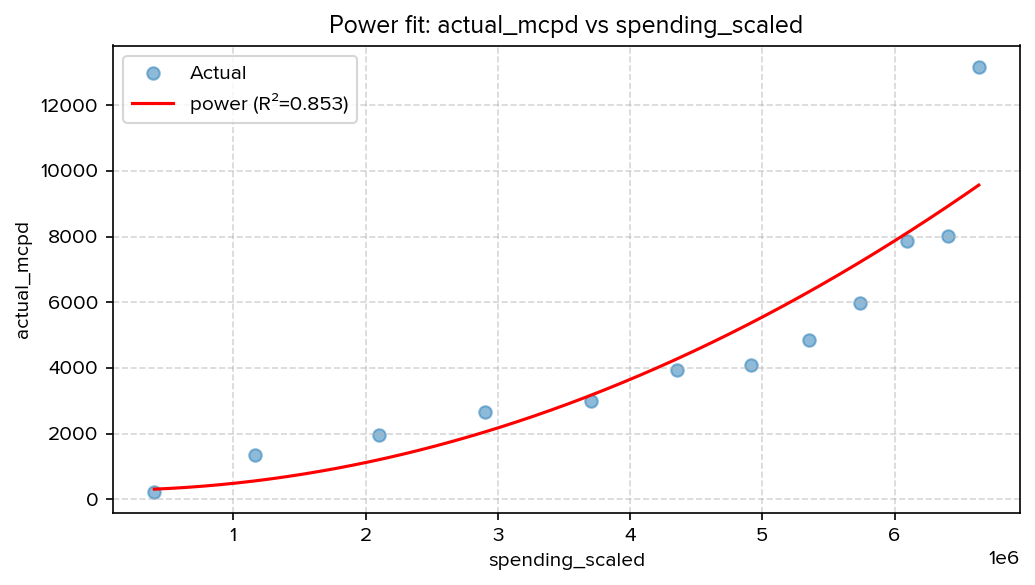


Fitted Models:
power     : actual_mcpd = 0.0000000002·(spending_scaled^2.0) + 273.0472115990   (R²=0.8528)

Best Model → power  (R²=0.8528)


In [49]:

# SHAPES = ["linear", "log", "sat_exp", "hill", "exp", "power", "quadratic"]
SHAPES = ["power"]

best_kind, best_formula, best_r2, results_df, best_fit_df = fit_all_curves(
   df_global_weighted[df_global_weighted['spending_scaled'] <= 7000000],
    x_col="spending_scaled",
    y_col="actual_mcpd",
    sat_exp=dict(scale=None),
    hill=dict(h=2, k=1000),
    power=dict(p=2.0),
)


In [50]:
df_spending_mcpd = best_fit_df.copy()
df_spending_mcpd.head()

,spending_scaled,_pow_x,actual_mcpd
0,402160.293571,1.617329e+11,307.168480
1,414655.504967,1.719392e+11,309.321731
2,427150.716364,1.824577e+11,311.540860
3,439645.927760,1.932885e+11,313.825867
4,452141.139156,2.044316e+11,316.176753


#### mCPD <> CPIH

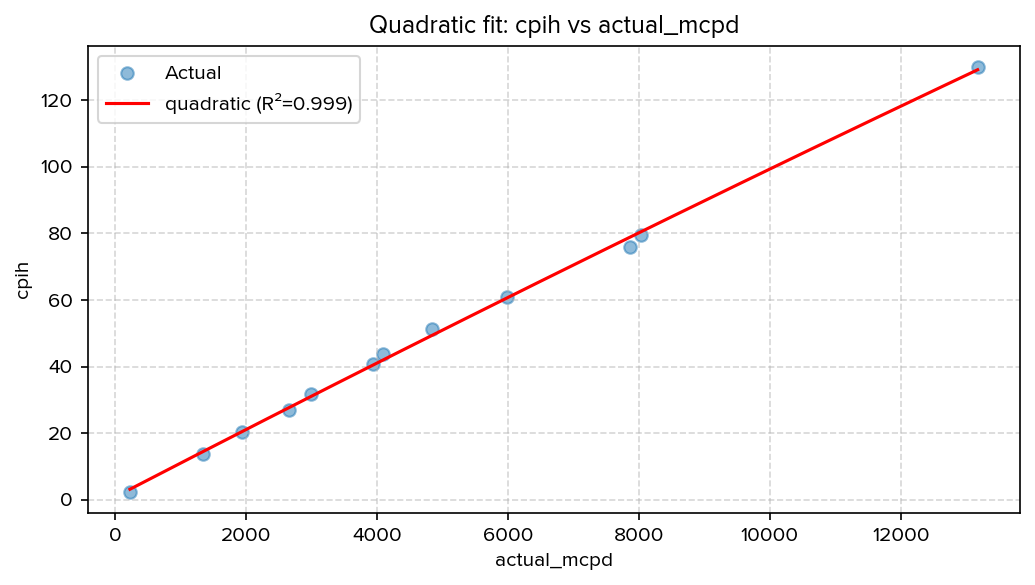


Fitted Models:
quadratic : cpih = -0.0000000345·actual_mcpd² + 0.010·actual_mcpd + 0.8497037550   (R²=0.9985)

Best Model → quadratic  (R²=0.9985)


In [51]:
# SHAPES = ["linear", "log", "sat_exp", "hill", "exp", "power", "quadratic"]
SHAPES = ["quadratic"]

best_kind, best_formula, best_r2, results_df, best_fit_df = fit_all_curves(
    df_global_weighted,
    x_col="actual_mcpd",
    y_col="cpih",
    sat_exp=dict(scale=None),
    hill=dict(h=2, k=1000),
    power=dict(p=2.0),
)

# results_df   # summary of all shapes
# print(best_fit_df.head())  # predictions for best model


In [52]:
df_mpcd_cpih = best_fit_df.copy()
df_mpcd_cpih.head()

,actual_mcpd,_x2,cpih
0,225.802987,50986.988825,3.150551
1,251.746602,63376.351419,3.414682
2,277.690216,77111.856317,3.678766
3,303.633831,92193.503519,3.942804
4,329.577446,108621.293024,4.206796


#### mCPD <> mCPIH

/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


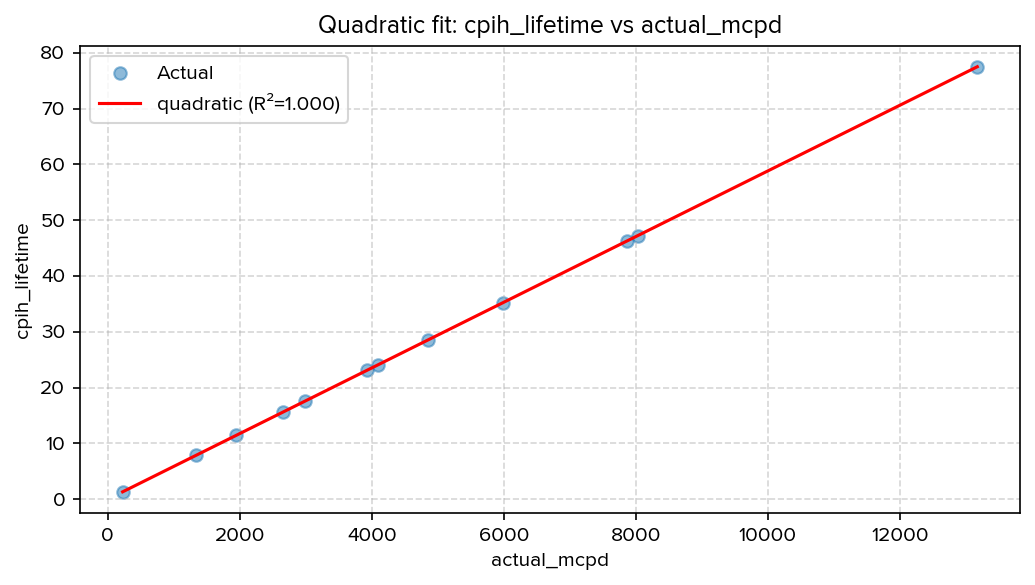


Fitted Models:
quadratic : cpih_lifetime = -0.0000000000·actual_mcpd² + 0.006·actual_mcpd + 0.0000000001   (R²=1.0000)

Best Model → quadratic  (R²=1.0000)


In [53]:
# SHAPES = ["linear", "log", "sat_exp", "hill", "exp", "power", "quadratic"]
SHAPES = ["quadratic"]

best_kind, best_formula, best_r2, results_df, best_fit_df = fit_all_curves(
    df_global_weighted,
    x_col="actual_mcpd",
    y_col="cpih_lifetime",
    sat_exp=dict(scale=None),
    hill=dict(h=2, k=1000),
    power=dict(p=2.0),
)

# results_df   # summary of all shapes
# print(best_fit_df.head())  # predictions for best model


In [54]:
df_mpcd_cpih_lifetime = best_fit_df.copy()
df_mpcd_cpih_lifetime.head()

,actual_mcpd,_x2,cpih_lifetime
0,225.802987,50986.988825,1.328253
1,251.746602,63376.351419,1.480862
2,277.690216,77111.856317,1.633472
3,303.633831,92193.503519,1.786081
4,329.577446,108621.293024,1.938691


#### Plot the chart

In [55]:
# Step 1: spending range (10k to 150k in steps of 10k)
spending = np.arange(1000000, 6800001, 200000)

# Step 2: MCPD formula (replace coefficients with yours)
def mcpd_formula(s):
    """
Fitted Models:
quadratic : actual_mcpd = 0.0000000000·spending_scaled² + 0.001·spending_scaled + 19.3573791791   (R²=0.9924)
Fitted Models:
power     : actual_mcpd = 0.0000000002·(spending_scaled^2.0) + 284.4490050542   (R²=0.8687)
    """

    # return (0.00000000001*(s**2) + 0.001*s +  19.3573791791)
    return (0.0000000002*(s**2) + 284.4490050542)

# Step 3: CPIH formula in terms of MCPD
def cpih_formula(m):
    """
    Fitted Models:
    quadratic : cpih = 0.0000000015·actual_mcpd² + 0.010·actual_mcpd + -0.3101666886   (R²=0.9996)
    
    
Fitted Models:
quadratic : cpih = -0.0000000692·actual_mcpd² + 0.011·actual_mcpd + -0.5039911843   (R²=0.9987)
    """

    return ( -0.0000000692*m**2 + 0.011*m + -0.5039911843)

def cpih_lifetime_formula(m):
    """
    Fitted Models:
    quadratic : cpih_lifetime = -0.0000000000·actual_mcpd² + 0.006·actual_mcpd + 0.0000000001   (R²=1.0000)
    """
    return (-0.00000000001*m**2 + 0.006*m + -0.0000000001 )


# Step 4: Compute values
mcpd = mcpd_formula(spending)
cpih = cpih_formula(mcpd)
cpih_lifetime = cpih_lifetime_formula(mcpd)

# Step 5: Build dataframe
df_new = pd.DataFrame({
    "spending": spending,
    "mcpd": mcpd,
    "cpih": cpih,
    "cpih_lifetime": cpih_lifetime
})

df_new


,spending,mcpd,cpih,cpih_lifetime
0,1000000,484.449005,4.808707,2.906692
1,1200000,572.449005,5.770271,3.434691
2,1400000,676.449005,6.905283,4.058689
3,1600000,796.449005,8.213052,4.778688
4,1800000,932.449005,9.692781,5.594685
5,2000000,1084.449005,11.343567,6.506682
6,2200000,1252.449005,13.164399,7.514678
7,2400000,1436.449005,15.154162,8.618673
8,2600000,1636.449005,17.311633,9.818667
9,2800000,1852.449005,19.635483,11.114660


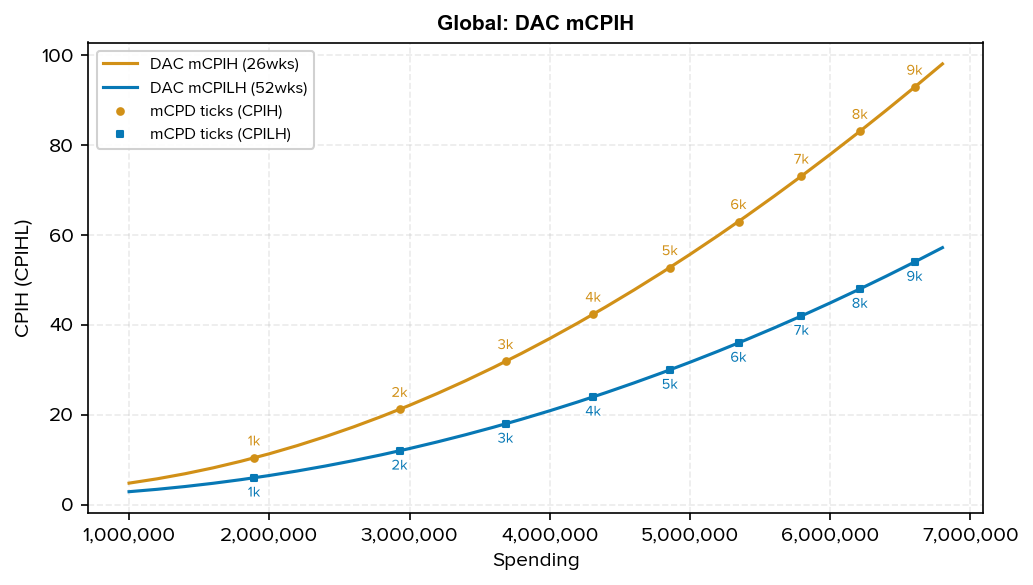

In [56]:
mcpd_levels = np.arange(1000, 10000, 1000)  # 1k..9k (adjust as needed)

# a, b, c = 0.00000000001, 0.001, 19.3573791791 
# # quadratic : actual_mcpd = 0.0000000000·spending_scaled² + 0.001·spending_scaled + 19.3573791791   (R²=0.9924)
# def spend_from_mcpd(m):
#     D = b**2 - 4*a*(c - m)
#     return (-b + np.sqrt(D)) / (2*a)

a = 0.0000000002
c = 284.4490050542 

# power     : actual_mcpd = 0.0000000002·(spending_scaled^2.0) + 284.4490050542   (R²=0.8687)

def spend_from_mcpd(m):
    m = np.asarray(m)  # ensure NumPy array
    # if np.any(m <= c):
        # raise ValueError(f"Some MCPD values are <= {c}, spending would be undefined.")
    return np.sqrt((m - c) / a)

# Exact spending values that produce those MCPD levels
spending_marks = spend_from_mcpd(mcpd_levels)
cpih_marks = cpih_formula(mcpd_levels)
cpih_lifetime_marks = cpih_lifetime_formula(mcpd_levels)

plt.rcParams.update({
    "figure.dpi": 150,                   # crisp display at normal size
    "savefig.dpi": 300,                  # high-res export
    "font.family": ["Proxima Nova", "Helvetica Neue", "Arial"],
    "axes.grid": True,
    "grid.alpha": 0.25,
    "grid.linestyle": "--",
    "axes.linewidth": 0.8,              
})

colors = {"cpih": "#d19017", "cpih_lifetime": "#0778b5", "dxo": "#038c0a", "dxo_cpih_15": "#403f3e"}

fig, ax = plt.subplots(figsize=(7, 4))   # regular size

line1, = ax.plot(df_new["spending"], df_new["cpih"], label="DAC mCPIH (26wks)", color=colors["cpih"], linewidth=1.5, zorder=2)
line2, = ax.plot(df_new["spending"], df_new["cpih_lifetime"], label="DAC mCPILH (52wks)", color=colors["cpih_lifetime"], linewidth=1.5, zorder=2)
# line3, = ax.plot(df_global_dxo["spending"], df_global_dxo["dxo_cpih"], label="DxO CPIH", color=colors["dxo"], linestyle="--", linewidth=1.5, zorder=1)
# line4, = ax.plot(df_global_dxo["spending"], df_global_dxo["dxo_cpih_15"], label="DxO CPIH ($15)", color=colors["dxo_cpih_15"], linestyle="--", linewidth=1.5, zorder=1)
# 5) Tick markers (smaller, same color as lines)
ax.scatter(spending_marks, cpih_marks, marker='o', s=10, color=colors["cpih"], zorder=3)
ax.scatter(spending_marks, cpih_lifetime_marks, marker='s', s=10, color=colors["cpih_lifetime"], zorder=3)

# 6) Annotations (CPIH above, Lifetime below) with subtle halo for readability
halo = [pe.withStroke(linewidth=2, foreground="white")]
for s, y, lvl in zip(spending_marks, cpih_marks, mcpd_levels):
    ax.annotate(f"{int(lvl/1000)}k", (s, y), xytext=(0, 6), textcoords="offset points", ha="center", fontsize=7, color=colors["cpih"], path_effects=halo)

for s, y, lvl in zip(spending_marks, cpih_lifetime_marks, mcpd_levels):
    ax.annotate(f"{int(lvl/1000)}k", (s, y), xytext=(0, -9), textcoords="offset points", ha="center", fontsize=7, color=colors["cpih_lifetime"], path_effects=halo)

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.8)
    spine.set_color("black")

ax.set_xlabel("Spending")
ax.set_ylabel("CPIH (CPIHL)")
# ax.set_title("Global: DAC vs DxO CPIH", fontfamily="Arial", fontweight="bold", fontsize = 10)
ax.set_title("Global: DAC mCPIH", fontfamily="Arial", fontweight="bold", fontsize = 10)
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))  # commas on x

mcpd_handle1 = ax.scatter([], [], marker='o', s=10, color=colors["cpih"], label="mCPD ticks (CPIH)")
mcpd_handle2 = ax.scatter([], [], marker='s', s=10, color=colors["cpih_lifetime"], label="mCPD ticks (CPILH)")
# mcpd_handle2 = ax.scatter([], [], marker='s', s=10, color=colors["cpih_lifetime"], label="mCPD ticks (CPILH)")
# ax.legend(handles=[line1, line2, line3, line4, mcpd_handle1, mcpd_handle2], fontsize=8, framealpha=0.9, loc="upper left")
ax.legend(handles=[line1, line2, mcpd_handle1, mcpd_handle2], fontsize=8, framealpha=0.9, loc="upper left")

fig.tight_layout()
plt.show()

In [57]:
merged_df = df_sm81_cohort_weighted.merge(
    df_sm0[['mcpd_scenario', 'spending']],  # include submarket_id explicitly
    on='mcpd_scenario',
    how='left',
    suffixes=('', '_sm0')
)


In [58]:
merged_df['spending_ratio'] = merged_df['spending'] / merged_df['spending_sm0']
merged_df

,mcpd_scenario,spending,applicants,new_dx,wad,hours,inc_spend,inc_applicants,inc_new_dx,inc_wad,inc_hours,inc_hours_lifetime,cpih,cpih_lifetime,cpiwad,actual_mcpd,spending_sm0,spending_ratio
0,1000,6955.957486,151.359375,32.789562,231.864459,2571.348680,6955.957486,151.359375,32.789562,231.864459,2571.348680,5574.225470,2.254316,1.247879,30.000102,212.139387,4.669642e+05,0.014896
1,2000,18115.001031,198.529643,42.006370,297.617688,3327.341419,11159.043546,47.170268,9.216809,65.753228,755.992739,1566.857471,12.300651,7.121926,169.710960,1210.727484,1.328705e+06,0.013634
2,3000,32888.596257,234.527302,49.898820,353.527379,3962.048141,14773.595225,35.997659,7.892450,55.909692,634.706722,1341.716425,19.396879,11.010967,264.240327,1871.864383,2.254686e+06,0.014587
3,4000,45027.575630,258.537965,54.725170,388.066232,4351.679743,12138.979373,24.010664,4.826350,34.538853,389.631602,820.479481,25.962515,14.794982,351.458671,2515.146986,3.036463e+06,0.014829
4,5000,55675.303527,274.632137,58.093252,412.124360,4626.502162,10647.727897,16.094171,3.368082,24.058128,274.822419,572.573978,32.286691,18.596248,442.583396,3161.362223,3.797443e+06,0.014661
5,6000,64904.202404,285.098058,60.378057,428.219268,4802.872619,9228.898878,10.465921,2.284805,16.094908,176.370457,388.416822,43.605654,23.760297,573.404894,4039.250415,4.425450e+06,0.014666
6,7000,72760.384871,293.434497,62.177589,440.844727,4940.326157,7856.182467,8.336439,1.799532,12.625459,137.453538,305.920492,47.629321,25.680472,622.249242,4365.680156,4.965759e+06,0.014652
7,8000,79312.979505,301.988774,63.600011,450.821328,5050.888106,6552.594634,8.554278,1.422422,9.976601,110.561949,241.811722,49.388561,27.097920,656.796286,4606.646363,5.418885e+06,0.014636
8,9000,84811.908827,306.983172,64.497439,457.135504,5122.120390,5498.929321,4.994398,0.897428,6.314176,71.232283,152.562724,64.330959,36.043728,870.886337,6127.433738,5.807385e+06,0.014604
9,10000,89448.881964,311.328964,65.184025,462.094802,5180.613751,4636.973138,4.345792,0.686586,4.959298,58.493361,116.719701,66.061246,39.727425,935.005857,6753.662195,6.118613e+06,0.014619


In [59]:
df_sm0_calc

,submarket_id,mcpd_scenario,spending,applicants,new_dx,wad,hours,inc_spend,inc_applicants,inc_new_dx,inc_wad,inc_hours,inc_hours_lifetime,cpih,cpih_lifetime,cpiwad,actual_mcpd,avg_cpih,avg_cpwad,hours_per_dx
0,0,1000,4.669642e+05,8169.743731,1703.735784,11969.157528,136629.136869,466964.214273,8169.743731,1703.735784,11969.157528,136629.136869,289635.083227,2.848125,1.612250,39.013958,274.082530,3.417750,39.013958,11.415101
1,0,2000,1.328705e+06,11808.890138,2405.857428,16920.316741,190258.651040,861740.667110,3639.146407,702.121644,4951.159213,53629.514172,119360.679489,13.390336,7.219636,174.048264,1227.338132,6.983677,78.527187,11.244391
2,0,3000,2.254686e+06,13956.571084,2823.832750,19876.235518,222269.328212,925980.824683,2147.680946,417.975322,2955.918777,32010.677171,71055.804786,24.106041,13.031741,313.263285,2215.395923,10.143935,113.436254,11.182667
3,0,4000,3.036463e+06,15298.070031,3073.467708,21655.563289,240817.524367,781777.335867,1341.498947,249.634958,1779.327771,18548.196155,42437.942788,35.123691,18.421660,439.366680,3131.682131,12.608979,140.216304,11.120354
4,0,5000,3.797443e+06,16405.958823,3275.364326,23090.265497,256056.970641,760979.724742,1107.888791,201.896618,1434.702208,15239.446274,34322.425104,41.612389,22.171502,530.409531,3769.155379,14.830460,164.460767,11.089390
5,0,6000,4.425450e+06,17112.736606,3408.040026,24029.971439,266072.319642,628007.121212,706.777783,132.675700,939.705942,10015.349001,22554.868981,52.253723,27.843528,668.301745,4733.399724,16.632508,184.163760,11.072519
6,0,7000,4.965759e+06,17630.457314,3512.724291,24775.138123,273588.690991,540308.945270,517.720708,104.684265,745.166684,7516.371349,17796.325069,59.903567,30.360703,725.084678,5161.319561,18.150454,200.433144,11.042872
7,0,8000,5.418885e+06,18106.955830,3602.525084,25415.959887,280102.242471,453125.915792,476.498516,89.800793,640.821763,6513.551480,15266.134884,57.972203,29.681771,707.101322,5045.901027,19.346096,213.207952,11.020723
8,0,9000,5.807385e+06,18527.999344,3684.558073,26004.698445,285788.006830,388500.293233,421.043514,82.032989,588.738559,5685.764359,13945.608058,56.940496,27.858254,659.885933,4735.903201,20.320604,223.320607,10.989860
9,0,10000,6.118613e+06,18914.321342,3753.626956,26504.556407,290120.197965,311227.886167,386.321999,69.068883,499.857962,4332.191136,11741.710076,59.867297,26.506180,622.632647,4506.050678,21.089924,230.851361,10.946050


In [60]:
df_sm81 = all_sms_daco_output[all_sms_daco_output['submarket_id'] == 81]
# drop two outlier points:
df_sm81 = df_sm81[df_sm81['mcpd_scenario'] <= 10000]

df_sm81 = df_sm81.groupby(['submarket_id','mcpd_scenario']).agg({
    'spending': 'mean',
    'applicants': 'mean',
    'new_dx': 'mean',
    'wad': 'mean',
    'hours': 'mean',
    'cpih': 'mean',
    'cpiwad': 'mean',
    'cpid': 'mean',
    'cp_wad': 'mean',
    'cp_hour': 'mean',
    'hours_per_dx': 'mean',
    'inc_spend': 'mean',
    'inc_apps': 'mean',
    'inc_new_dx': 'mean',
    'inc_wad': 'mean',
    'inc_hours': 'mean',
    'inc_spend_final': 'mean',
    'inc_apps_final': 'mean',
    'inc_new_dx_final': 'mean',
    'inc_wad_final': 'mean',
    'inc_hours_final': 'mean',
    'inc_hours_lifetime': 'mean',
    'cpih_lifetime': 'mean',
}).reset_index()

df_sm81

KeyError: "Column(s) ['cp_hour', 'cp_wad', 'cpid', 'cpih', 'cpih_lifetime', 'cpiwad', 'hours_per_dx', 'inc_apps', 'inc_apps_final', 'inc_hours', 'inc_hours_final', 'inc_hours_lifetime', 'inc_new_dx', 'inc_new_dx_final', 'inc_spend', 'inc_spend_final', 'inc_wad', 'inc_wad_final'] do not exist"

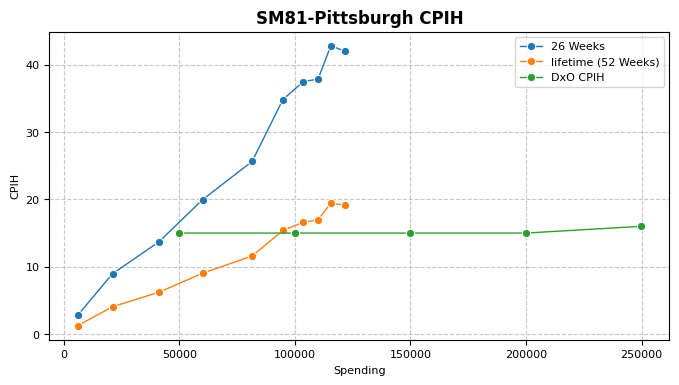

In [ ]:

plt.figure(figsize=(8, 4))
# mcpd_scenario
sns.lineplot(data=df_sm81, x='spending', y='cpih', marker='o', label='26 Weeks', linewidth=1)
sns.lineplot(data=df_sm81, x='spending', y='cpih_lifetime', marker='o', label= 'lifetime (52 Weeks)', linewidth=1)
sns.lineplot(data=df_dxo, x='spending', y='dxo_cpih', marker='o', label='DxO CPIH', linewidth=1)
# Customize the plot
plt.title(f'SM81-Pittsburgh CPIH', fontsize=12, fontweight='bold')
plt.xlabel('Spending', fontsize=8)
plt.ylabel('CPIH', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=8)
# Show the plot
plt.show()

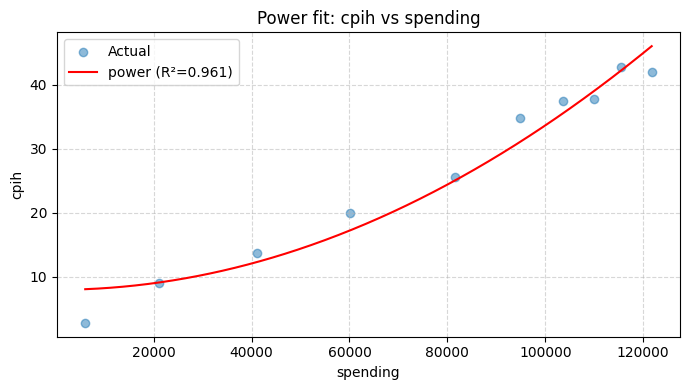


Fitted Models:
power     : cpih = 0.000·(spending^2.0) + 7.961   (R²=0.9613)

Best Model → power  (R²=0.9613)
[run_regression] Auto-selected scale=1.787e-05 for sat_exp


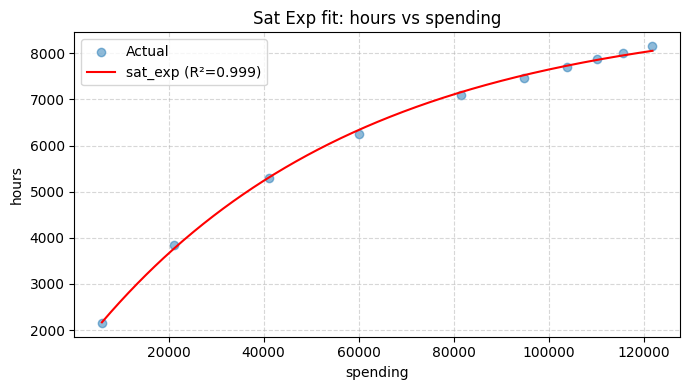


Fitted Models:
sat_exp   : hours = 7500.174·(1 − exp(−1.79e-05·spending)) + 1404.760   (R²=0.9990)

Best Model → sat_exp  (R²=0.9990)


In [ ]:
# good but unreachable curve: paid_media_spend vs paid_media_applicants
SHAPES = ["power"]
best_kind, best_formula, best_r2 = fit_all_curves(
    df_sm81,
    x_col="spending",
    y_col="cpih",
    # y_col_lifetime="cpih_lifetime",
    # optional per-shape tweaks
    sat_exp=dict(scale=None),          # let auto-tune
    hill=dict(h=2, k=1000),
)

SHAPES = ["sat_exp"]
best_kind, best_formula, best_r2 = fit_all_curves(
    df_sm81,
    x_col="spending",
    y_col="hours",
    # optional per-shape tweaks
    sat_exp=dict(scale=None),          # let auto-tune
    hill=dict(h=2, k=1000),
)

In [ ]:
df_sm81_cohort[(df_sm81_cohort['submarket_id'] == 34) & (df_sm81_cohort['spend_date'] == '2025-10-27')]

,spend_date,submarket_id,spending,applicants,new_dx,wad,hours,cpa,cpd,cp_wad,...,inc_hours_final,cpih,cpih_adj,hours_per_dx,cpiwad,cpid,lifetime_hours,inc_hours_lifetime,cpih_lifetime,total_deliveries
0,2025-10-27,34,13002.61554,246.761830,59.462247,397.408397,4434.127864,52.692978,218.670099,32.718522,...,4434.127864,2.932395,2.932395,11.157610,32.718522,218.670099,1.718459e+06,10108.582059,1.286295,353174
1,2025-10-27,34,25102.61554,313.264696,76.642828,512.298151,5716.028782,80.132284,327.527263,49.000012,...,1281.900918,9.439107,9.439107,11.157661,105.318356,704.283552,2.214978e+06,2920.698624,4.142844,353174
2,2025-10-27,34,40502.61554,356.897208,87.533422,584.941854,6526.590181,113.485381,462.710295,69.242123,...,810.561400,18.999178,18.999178,11.158041,211.993600,1414.064210,2.529716e+06,1851.401076,8.318025,353174
3,2025-10-27,34,59002.61554,393.255070,96.661537,645.836532,7206.055928,150.036503,610.404276,91.358436,...,679.465746,27.227274,27.227274,11.158048,303.803231,2026.705401,2.793518e+06,1551.779553,11.921796,353174
4,2025-10-27,34,77987.16954,445.457932,106.350270,710.519866,7927.802047,175.071907,733.304856,109.760716,...,721.746120,26.303645,26.303645,11.158147,293.499930,1959.446502,3.073523e+06,1647.084611,11.526156,353174
5,2025-10-27,34,97487.16954,470.805248,112.474469,751.299258,8382.833482,207.064747,866.749322,129.758107,...,455.031435,42.854182,42.854182,11.158367,478.182701,3184.090084,3.250512e+06,1041.113760,18.729942,353174
6,2025-10-27,34,118950.71654,493.712954,118.067786,788.556587,8798.562971,240.930921,1007.478166,150.846139,...,415.729489,51.628637,51.628637,11.158328,576.089270,3837.355495,3.412159e+06,950.863946,22.572679,353174
7,2025-10-27,34,131441.62086,512.090595,121.666117,812.357644,9064.163613,256.676499,1080.346966,161.802652,...,265.600641,47.028894,47.028894,11.159195,524.804601,3471.304566,3.516151e+06,611.716343,20.419439,353174
8,2025-10-27,34,141541.62086,528.692480,124.650309,832.038496,9283.792941,267.720132,1135.509591,170.114269,...,219.629328,45.986572,45.986572,11.159544,513.189157,3384.501779,3.602394e+06,507.312483,19.908834,353174
9,2025-10-27,34,147605.40171,537.669646,126.302715,842.919017,9405.217467,274.528054,1168.663727,175.112198,...,121.424526,49.938682,49.938682,11.159808,557.306091,3669.666554,3.650148e+06,280.909104,21.586274,353174


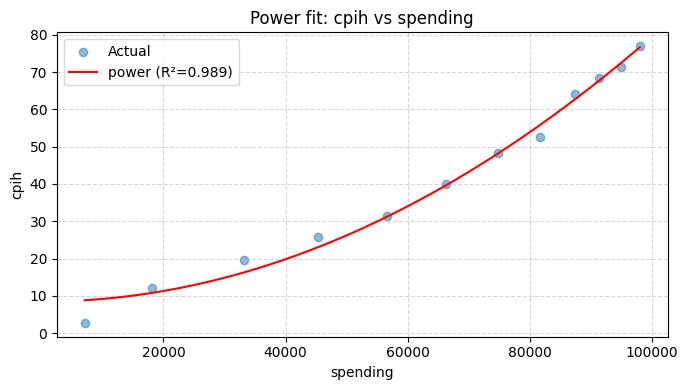


Fitted Models:
power     : cpih = 0.000·(spending^2.0) + 8.436   (R²=0.9895)

Best Model → power  (R²=0.9895)
[run_regression] Auto-selected scale=2.228e-05 for sat_exp


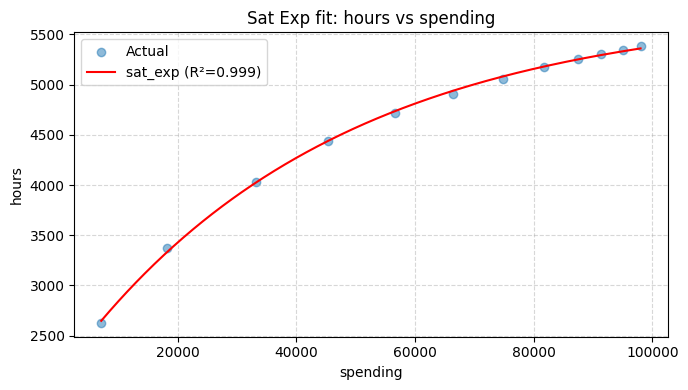


Fitted Models:
sat_exp   : hours = 3662.949·(1 − exp(−2.23e-05·spending)) + 2110.694   (R²=0.9994)

Best Model → sat_exp  (R²=0.9994)


In [ ]:
# good but unreachable curve: paid_media_spend vs paid_media_applicants
SHAPES = ["power"]
best_kind, best_formula, best_r2 = fit_all_curves(
    df_sm81_cohort_weighted,
    x_col="spending",
    y_col="cpih",
    # optional per-shape tweaks
    sat_exp=dict(scale=None),          # let auto-tune
    hill=dict(h=2, k=1000),
)

SHAPES = ["sat_exp"]
best_kind, best_formula, best_r2 = fit_all_curves(
    df_sm81_cohort_weighted,
    x_col="spending",
    y_col="hours",
    # optional per-shape tweaks
    sat_exp=dict(scale=None),          # let auto-tune
    hill=dict(h=2, k=1000),
)